## 参考文献汇总
- Reference 1: Kaggle Kernel [Code sharing, 13th place, no external data](https://www.kaggle.com/c/rossmann-store-sales/discussion/17979)
- Reference 2: Kaggle Kernel-[A Journey through Rossmann Stores](https://www.kaggle.com/omarelgabry/rossmann-store-sales/a-journey-through-rossmann-stores)
- Reference 3: Kaggle Kernel-[Predict_sales_with_pandas](https://www.kaggle.com/zygmunt/rossmann-store-sales/predict-sales-with-pandas-py)
- Reference 4:[XGBoost:Notes on Parameter Tuning](http://xgboost.readthedocs.io/en/latest/how_to/param_tuning.html)
- Reference 5:[XGBoost Parameters](http://xgboost.readthedocs.io/en/latest/parameter.html)
- Reference 6:[Complete Guide to Parameter Tuning in XGBoost (with codes in Python)](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)
- Reference 7:[XGBoost Feature Importance](https://www.kaggle.com/cast42/rossmann-store-sales/xgboost-in-python-with-rmspe-v2)


## 文档使用说明
1. 运行程序前，从[Kaggle](https://www.kaggle.com/c/rossmann-store-sales/data)官网下载数据store.csv.zip和train.csv.zip，将解压后的store.csv和train.csv放在与本文档同目录下的data文件夹中
2. section 0为准备工作，每次运行该程序都需要执行
3. section 1会生成后续数据可视化、模型训练所需要的数据，运行一次后将会在该程序同目录下生成文件
4. section 2为数据可视化，在section 1运行成功后，可以只运行section 0和2来完成；
5. section 3为生成基准模型，在section 1运行成功后，可以只运行section 0和3来完成；
6. section 4/5为生成基准模型，在section 1运行成功后，可以只运行section 0和4/5来完成；


## 准备工作
### 0.1 调入库函数

In [1]:

#基本计算类
import pandas as pd
import numpy as np
from pandas import Series,DataFrame

#可视化
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display 

#xgboost库函数
import xgboost as xgb


#时间类
import time
import datetime
from isoweek import Week

#文件类
import os

#其他
import itertools
import operator

#基本设定

%matplotlib inline
sns.set_style('whitegrid')

### 0.2 定义评估指标
本项目采用Kaggle比赛的评估指标：RMSPE（误差百分比的均方差），可表示为
$$
RMSPE= \sqrt{\frac{1}{n}\sum_{i=1}^{n}(\frac{y_i-\hat{y_i}}{y_i})^2}
$$
其中，任何当天销售额为0的数据在评估时将被忽略； $y_i$ 表示某药店在某天的实际销售额，而$\hat{y_i}$ 表示该药店在对应这一天的预测销售额。

### 0.3 Setting seed

In [2]:
seed_1=42

## 1. 读入数据，基本数据处理 & 预览数据

### 1.1 读入数据
#### 1.1.0 读入数据

In [3]:
train_raw_df=pd.read_csv('data/train.csv',low_memory=False)
# test_raw_df=pd.read_csv('data/test.csv',low_memory=False)
store_raw_df=pd.read_csv('data/store.csv',low_memory=False)

#### 1.1.1 数据探索

In [4]:
### 对数据进行预览 1
print('--------train.csv---------')
display(train_raw_df.head(n=2))

print('--------store.csv---------')
display(store_raw_df.head(n=2))

--------train.csv---------


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1


--------store.csv---------


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"


In [5]:
#对数据进行预览 2
print('--------train.csv---------')
train_raw_df.info()
print('--------store.csv---------')
store_raw_df.info()

--------train.csv---------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null object
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: int64(7), object(2)
memory usage: 69.8+ MB
--------store.csv---------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2        

In [6]:
print('--------store.csv---------')
store_raw_df.describe()

--------store.csv---------


/Users/pengjuzhao/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,NaN,NaN,NaN,0.000000,NaN,NaN
50%,558.00000,NaN,NaN,NaN,1.000000,NaN,NaN
75%,836.50000,NaN,NaN,NaN,1.000000,NaN,NaN
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


In [7]:
#对数据进行预览 3
print('--------train.csv---------')
train_raw_df.describe()

--------train.csv---------


,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


#### 1.1.2 train.csv数据探索

In [8]:
print'max store id:',train_raw_df.Store.unique().max()
print'min store id:',train_raw_df.Store.unique().min()

max store id: 1115
min store id: 1


In [9]:
print'max DayOfWeek:',train_raw_df.DayOfWeek.unique().max()
print'min DayOfWeek:',train_raw_df.DayOfWeek.unique().min()

max DayOfWeek: 7
min DayOfWeek: 1


In [10]:
print'ealiest date:',train_raw_df.Date.unique().min()
print'latest date:',train_raw_df.Date.unique().max()

ealiest date: 2013-01-01
latest date: 2015-07-31


In [11]:
print 'Open Unique value:', train_raw_df.Open.unique()

Open Unique value: [1 0]


In [12]:
print 'Promo Unique value:', train_raw_df.Promo.unique()

Promo Unique value: [1 0]


In [13]:
print 'StateHoliday Unique value:', train_raw_df.StateHoliday.unique()

StateHoliday Unique value: ['0' 'a' 'b' 'c']


In [14]:
print 'SchoolHoliday Unique value:', train_raw_df.SchoolHoliday.unique()

SchoolHoliday Unique value: [1 0]


#### 1.1.3 train.csv数据探索

In [15]:
print 'StoreType:',store_raw_df.StoreType.unique()

StoreType: ['c' 'a' 'd' 'b']


In [16]:
print 'Assortment:',store_raw_df.Assortment.unique()

Assortment: ['a' 'c' 'b']


In [17]:
print 'Promo2:',store_raw_df.Promo2.unique()

Promo2: [0 1]


In [18]:
print 'PromoInterval:',store_raw_df.PromoInterval.unique()

PromoInterval: [nan 'Jan,Apr,Jul,Oct' 'Feb,May,Aug,Nov' 'Mar,Jun,Sept,Dec']


### 1.2  train_raw_df，test_raw_df数据处理
#### 1.2.1 train_raw_df，test_raw_df的时间数据处理
- Year,Month,Day
- DaysThisYear

In [19]:
#将str格式Date转换为datetime64格式Date
train_raw_df['Date_time']=pd.to_datetime(train_raw_df['Date'])
#提取int格式的Year，Month，Day
var_name='Date_time'
train_raw_df['Year']=( pd.Index(train_raw_df[var_name]).year).astype(np.int64)
train_raw_df['Month']=( pd.Index(train_raw_df[var_name]).month).astype(np.int64)
train_raw_df['Day']=( pd.Index(train_raw_df[var_name]).day).astype(np.int64)
train_raw_df['Year-Month']=train_raw_df['Date'].apply(lambda x:(str(x)[:7]))

#将Month转换为string
month2str={
    1:'Jan',2:'Feb',3:'Mar',4:'Apr',
    5:'May',6:'Jun',7:'Jul',8:'Aug',
    9:'Sept',10:'Oct',11:'Nov',12:'Dec'
}
train_raw_df['Month-Str']=train_raw_df['Month'].map(month2str)
train_raw_df['DayOfYear']=train_raw_df.Date_time.dt.dayofyear

#### 1.2.2 处理test_raw_df Open特征的缺失值
- 由评估指标 RMSPE（误差百分比的均方差）的定义可知，RMSPE仅与非零Sales有关；同时考虑到所有Open=0时，Sales也为0，那么将Open的缺失值全部设置为1，将不会引入新的误差：
    - 如果缺失值对应的实际Sales为零，那么即使预测Sales非零，也不会被计算入RMSPE；
    - 如果缺失值对应的实际Sales非零，那么预测Sales将会被计算入RMSPE；

#### 1.2.3 将train_raw_df中的Sales转换为SalesLog

In [20]:
train_raw_df['SalesLog']=np.log(train_raw_df['Sales'])

#### 1.2.4 将train_raw_df，test_raw_df的StateHoliday转换为分类数据

In [21]:
StateHoliday_dict={
    '0':0, 'a':1, 'b':2, 'c':3
}
train_raw_df['StateHoliday_cat']=train_raw_df['StateHoliday'].map(StateHoliday_dict)

#### 1.2.5 train_raw_df异常值处理
- 在模型训练过程中，使用高质量的训练数据是非常重要的，其中一个重要方面是要剔除异常值
- 使用MAD（median absolute deviation）方法来标记异常值

In [22]:
def mad_based_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh


for i in train_raw_df['Store'].unique():    
    train_raw_df.loc[(train_raw_df['Store'] == i) & (train_raw_df['Open'] == 1), 'Outlier_3'] = \
        mad_based_outlier(train_raw_df.loc[ (train_raw_df['Store'] == i) & (train_raw_df['Open'] == 1)]['Sales'], 3)

### 1.3 store_raw_df数据处理
#### 1.3.1 store_raw_df的Competition数据处理
- 目的：
    - store_raw_df中添加特征InCompetition，CompetitionSinceDate
    - 当CompetitionDistance为缺省值时，CompetitionOpenSinceMonth，CompetitionOpenSinceYear亦同时为缺省值，在这种情况下，假定该药店开始竞争的时间为train.csv统计时间结束时（取为2016-01-01），而竞争距离为CompetitionDistance的中位数；
    - 当CompetitionDistance不缺省值，而CompetitionOpenSinceMonth，CompetitionOpenSinceYear为缺省值时，假定Competition开始时间太早而无法统计到，将其统一设置为CompetitionOpenSinceMonth/Year的最早值1961-01-01。

- 通过验证可知，CompetitionOpenSinceYear与CompetitionOpenSinceMonth同时为NaN or 非NaN
- 如果CompetitionDistance 或者CompetitionOpenSinceMonth/Year其中一个不为NaN，则认为该store的InCompetition为True;
- 对于CompetitionDistance不为NaN，而CompetitionOpenSinceMonth为NaN的store，**假设**认为Competition开始时间太早而无法统计到，将其统一设置为CompetitionOpenSinceMonth/Year的最早值1961-01-01
- 对于CompetitionDistance为NaN的store，**假设** CompetitionOpenSinceMonth /Year 设定为一个在test样本之后的日期2016-01-01,CompetitionDistance的缺失值设为中位数。

In [23]:
store_raw_df[store_raw_df.CompetitionDistance.isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [24]:
print("count of CompetitionOpenSinceYear!=CompetitionOpenSinceMonth is {}".format(
        np.sum(store_raw_df.CompetitionOpenSinceYear.isnull()!=store_raw_df.CompetitionOpenSinceMonth.isnull()
              )))

#如果CompetitionDistance 或者CompetitionOpenSinceMonth/Year其中一个不为NaN，则认为该store的InCompetition为True
store_raw_df['InCompetition']=0
store_raw_df['InCompetition']=np.logical_or(
        store_raw_df.CompetitionDistance.notnull(),
        store_raw_df.CompetitionOpenSinceMonth.notnull())

# store_raw_df中CompetitionDistance为NaN的设为CompetitionDistance的中位数
store_raw_df['CompetitionDistance'].fillna(
    np.median(store_raw_df['CompetitionDistance'][store_raw_df['CompetitionDistance'].notnull()]),
    inplace=True)
#将CompetitionDistance不为NaN，而CompetitionOpenSinceMonth/Year为NaN设置为1961-01-01
store_raw_df['CompetitionOpenSinceYear'].fillna(1961,inplace=True)
store_raw_df['CompetitionOpenSinceMonth'].fillna(1,inplace=True)
# 将CompetitionDistance为NaN的CompetitionOpenSinceMonth/Year设置为2016-01-01
store_raw_df.loc[store_raw_df['InCompetition']==0,'CompetitionOpenSinceYear']=2016
# 将CompetitionOpenSinceMonth/Year格式改为np.int64
store_raw_df['CompetitionOpenSinceMonth']=store_raw_df['CompetitionOpenSinceMonth'].astype(np.int64)
store_raw_df['CompetitionOpenSinceYear']=store_raw_df['CompetitionOpenSinceYear'].astype(np.int64)

for index, row in store_raw_df.iterrows():
    store_raw_df.loc[index,'CompetitionSinceDate']=(pd.to_datetime(str(row['CompetitionOpenSinceYear'])+'-'+str(row['CompetitionOpenSinceMonth'])+'-'+str(1)))

count of CompetitionOpenSinceYear!=CompetitionOpenSinceMonth is 0


In [25]:
print 'CompetitionDistance，CompetitionOpenSinceMonth，CompetitionOpenSinceYear同时为缺省值时替换后的结果：'
store_raw_df[store_raw_df['InCompetition']==0]

CompetitionDistance，CompetitionOpenSinceMonth，CompetitionOpenSinceYear同时为缺省值时替换后的结果：


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,InCompetition,CompetitionSinceDate
290,291,d,a,2325.0,1,2016,0,NaN,NaN,NaN,False,2016-01-01
621,622,a,c,2325.0,1,2016,0,NaN,NaN,NaN,False,2016-01-01
878,879,d,a,2325.0,1,2016,1,5.0,2013.0,"Feb,May,Aug,Nov",False,2016-01-01


In [26]:
print 'CompetitionDistance不缺省，而CompetitionOpenSinceMonth，CompetitionOpenSinceYear为缺省值时替换后的结果：'
store_raw_df[store_raw_df['CompetitionOpenSinceYear']==1961].head()

CompetitionDistance不缺省，而CompetitionOpenSinceMonth，CompetitionOpenSinceYear为缺省值时替换后的结果：


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,InCompetition,CompetitionSinceDate
11,12,a,c,1070.0,1,1961,1,13.0,2010.0,"Jan,Apr,Jul,Oct",True,1961-01-01
12,13,d,a,310.0,1,1961,1,45.0,2009.0,"Feb,May,Aug,Nov",True,1961-01-01
15,16,a,c,3270.0,1,1961,0,NaN,NaN,NaN,True,1961-01-01
18,19,a,c,3240.0,1,1961,1,22.0,2011.0,"Mar,Jun,Sept,Dec",True,1961-01-01
21,22,a,a,1040.0,1,1961,1,22.0,2012.0,"Jan,Apr,Jul,Oct",True,1961-01-01


#### 1.3.2 store_raw_df的Promo数据处理
- 目的：
    - store_raw_df中添加特征Promo2SinceDate
    - PromoInterval 将缺失值替代为''
- 如果Promo2为0，那么Promo2SinceDate为test样本之后的日期(本项目取为2016-W1-Monday)

In [27]:
# 将所有为Promo2为0的Promo2SinceWeek/Year设置为2016 Week-01
store_raw_df['Promo2SinceWeek'].fillna(1,inplace=True)
store_raw_df['Promo2SinceYear'].fillna(2016,inplace=True)
# 将Promo2SinceWeek/Year格式改为np.int64
store_raw_df['Promo2SinceWeek']=store_raw_df['Promo2SinceWeek'].astype(np.int64)
store_raw_df['Promo2SinceYear']=store_raw_df['Promo2SinceYear'].astype(np.int64)

for index, row in store_raw_df.iterrows():
    store_raw_df.loc[index,'Promo2SinceDate']=Week(row['Promo2SinceYear'], row['Promo2SinceWeek'] ).monday()

store_raw_df['PromoInterval'].fillna('',inplace=True)

#### 1.3.3 处理store_raw_df的StoreType和Assortment
- 转换为分类特征

In [28]:
store_raw_df['StoreType_cat'] = store_raw_df['StoreType'].astype('category').cat.codes.astype(np.int64)
store_raw_df['Assortment_cat'] = store_raw_df['Assortment'].astype('category').cat.codes.astype(np.int64)

### 1.4 将train和store数据进行合并，并进行处理
#### 1.4.1 将train和store数据进行合并

In [29]:
train_store_raw_df=train_raw_df.merge(store_raw_df,on='Store')


#### 1.4.2 train_store_raw_df,test_store_raw_df中的Competition数据处理
- 目的：
    - train_store_raw_df中添加特征InCompetitionToday,DaysCountSinceCompetition
    - 注意：在计算好的DaysCountSinceCompetition后加1，这样如果已经开始Competition的药店最小值为1，而DaysCountSinceCompetition为0时仅表示那些还没有开始竞争的药店；

In [30]:
#train_store_raw_df中添加特征InCompetitionToday,DaysCountSinceCompetition
train_store_raw_df['InCompetitionToday']=pd.to_datetime(train_store_raw_df['CompetitionSinceDate'])<(train_store_raw_df['Date_time'])
train_store_raw_df['DaysCountSinceCompetition']=0

mask=train_store_raw_df['InCompetitionToday']==True
train_store_raw_df.loc[mask,'DaysCountSinceCompetition']=(((train_store_raw_df.loc[mask,'Date_time'])-pd.to_datetime(train_store_raw_df.loc[mask,'CompetitionSinceDate'])) / np.timedelta64(1, 'D')).astype(int)+1.0



#### 1.4.3 train_store_raw_df中的Promo2数据处理
- 目的：
    - train_store_raw_df中添加特征InPromo2Today,DaysCountSincePromo2
    - 注意：在计算好的天数后加1，这样如果已经开始Promo2的药店最小值为1，而DaysCountSincePromo2为0时仅表示那些还没有开始促销的药店；

In [31]:
train_store_raw_df['InPromo2Today']=0
mask=(pd.to_datetime(train_store_raw_df['Promo2SinceDate'])<(train_store_raw_df['Date_time']))&(train_store_raw_df['PromoInterval']!='')
for interval in train_store_raw_df[mask].PromoInterval.unique():
    for month in interval.split(','):
        train_store_raw_df.loc[mask & (train_store_raw_df['Month-Str']==month)&(train_store_raw_df['PromoInterval']==interval) ,
                              'InPromo2Today']=1        
        
train_store_raw_df['DaysCountSincePromo2']=0
mask=train_store_raw_df['InPromo2Today']==True
train_store_raw_df.loc[mask,'DaysCountSincePromo2']=(((train_store_raw_df.loc[mask,'Date_time'])-pd.to_datetime(train_store_raw_df.loc[mask,'Promo2SinceDate'])) / np.timedelta64(1, 'D')).astype(int)+1.0

### 1.5 数据范围调整
- 将连续量离散，方便进行embedding操作
- 调整参数
    - CompetitionDistance -->log2
    - DaysCountSincePromo2 --> log2
    - DaysCountSinceCompetition ---> log2

In [32]:
train_store_raw_df['CompetitionDistance_log']=np.round(np.log2(train_store_raw_df['CompetitionDistance']+1.0))
train_store_raw_df['DaysCountSinceCompetition_log']=np.round(np.log2(train_store_raw_df['DaysCountSinceCompetition']+1.0))
train_store_raw_df['DaysCountSincePromo2_log']=np.round(np.log2(train_store_raw_df['DaysCountSincePromo2']+1.0))

In [33]:
train_store_raw_df['CompetitionDistance_log'].unique()

array([ 10.,   9.,  14.,  15.,   8.,  13.,  11.,  12.,   6.,   5.,   7.,
        16.,   4.])

### 1.6 预览数据

In [34]:
### 对数据进行预览 1
print('--------train.csv---------')
display(train_raw_df.head(n=2))

print('--------store.csv---------')
display(store_raw_df.head(n=2))
print('--------train_store_raw_df---------')
display(train_store_raw_df.head(n=2))


--------train.csv---------


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Date_time,Year,Month,Day,Year-Month,Month-Str,DayOfYear,SalesLog,StateHoliday_cat,Outlier_3
0,1,5,2015-07-31,5263,555,1,1,0,1,2015-07-31,2015,7,31,2015-07,Jul,212,8.568456,0,False
1,2,5,2015-07-31,6064,625,1,1,0,1,2015-07-31,2015,7,31,2015-07,Jul,212,8.710125,0,False


--------store.csv---------


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,InCompetition,CompetitionSinceDate,Promo2SinceDate,StoreType_cat,Assortment_cat
0,1,c,a,1270.0,9,2008,0,1,2016,,True,2008-09-01,2016-01-04,2,0
1,2,a,a,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",True,2007-11-01,2010-03-29,0,0


--------train_store_raw_df---------


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Date_time,...,Promo2SinceDate,StoreType_cat,Assortment_cat,InCompetitionToday,DaysCountSinceCompetition,InPromo2Today,DaysCountSincePromo2,CompetitionDistance_log,DaysCountSinceCompetition_log,DaysCountSincePromo2_log
0,1,5,2015-07-31,5263,555,1,1,0,1,2015-07-31,...,2016-01-04,2,0,True,2525.0,0,0.0,10.0,11.0,0.0
1,1,4,2015-07-30,5020,546,1,1,0,1,2015-07-30,...,2016-01-04,2,0,True,2524.0,0,0.0,10.0,11.0,0.0


In [35]:
#对数据进行预览 2
print('--------train.csv---------')
train_raw_df.info()

print('--------store.csv---------')
store_raw_df.info()
print('--------train_store_raw_df---------')
train_store_raw_df.info()


--------train.csv---------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 19 columns):
Store               1017209 non-null int64
DayOfWeek           1017209 non-null int64
Date                1017209 non-null object
Sales               1017209 non-null int64
Customers           1017209 non-null int64
Open                1017209 non-null int64
Promo               1017209 non-null int64
StateHoliday        1017209 non-null object
SchoolHoliday       1017209 non-null int64
Date_time           1017209 non-null datetime64[ns]
Year                1017209 non-null int64
Month               1017209 non-null int64
Day                 1017209 non-null int64
Year-Month          1017209 non-null object
Month-Str           1017209 non-null object
DayOfYear           1017209 non-null int64
SalesLog            1017209 non-null float64
StateHoliday_cat    1017209 non-null int64
Outlier_3           844392 non-null object
dtypes: datetime64[ns](1), f

### 1.6 将处理好的数据保存本地硬盘
- feature_x_list & feature_y_list
- train_store_raw_df & test_store_raw_df

In [36]:
#feature
feature_x_list=['Store','DayOfWeek',
                'Year','Month','Day','DayOfYear',
                
                'StoreType_cat','Assortment_cat','StateHoliday_cat','SchoolHoliday',
                
                'Promo','Promo2','InPromo2Today','DaysCountSinceCompetition_log',


                'InCompetition',
                'InCompetitionToday','CompetitionDistance_log','DaysCountSincePromo2_log'                
               ]
feature_y_list=['Sales']
#write file
file_train_store_raw_df='train_store_raw_df.pickle'

file_feature='feature_x_list.pickle'
path='Capstone_Project_Rossman_Sales_Prediction_1'

train_store_raw_df.to_pickle(os.path.join(path, file_train_store_raw_df))


(pd.Series(feature_x_list)).to_pickle(os.path.join(path, file_feature))

file_train_raw_df='train_raw_df.pickle'
train_raw_df.to_pickle(os.path.join(path, file_train_raw_df))

file_store_raw_df='store_raw_df.pickle'
store_raw_df.to_pickle(os.path.join(path, file_store_raw_df))


## 2.数据可视化

###  2.0 将处理好的数据从本地硬盘读入

In [37]:
file_train_store_raw_df='train_store_raw_df.pickle'

file_feature='feature_x_list.pickle'
file_train_raw_df='train_raw_df.pickle'
file_store_raw_df='store_raw_df.pickle'
path='Capstone_Project_Rossman_Sales_Prediction_1'

train_raw_df=pd.read_pickle(os.path.join(path, file_train_raw_df))

store_raw_df=pd.read_pickle(os.path.join(path, file_store_raw_df))

train_store_raw_df=pd.read_pickle(os.path.join(path, file_train_store_raw_df))

train_store_raw_df=pd.read_pickle(os.path.join(path, file_train_store_raw_df))

feature_x_list=pd.read_pickle(os.path.join(path, file_feature)).tolist()

### 2.1 Open & DayOfWeek

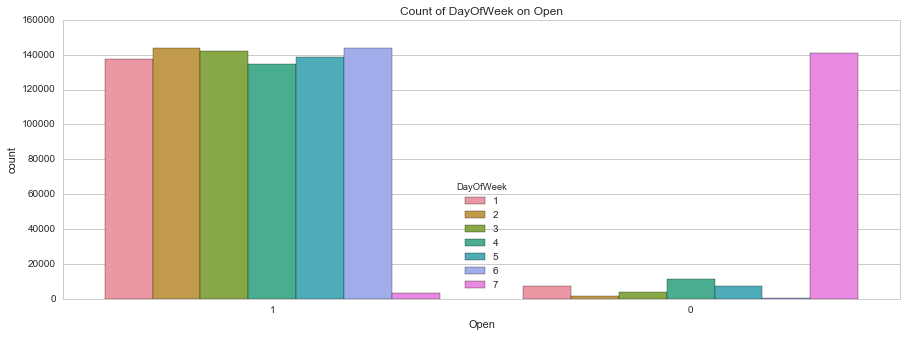

In [38]:
# Count of DayOfWeek on Open
fig,axis1=plt.subplots(1,1,figsize=(15,5))
plt.title('Count of DayOfWeek on Open')
sns.countplot(x='Open',hue='DayOfWeek',data=train_raw_df,order=[1,0])

### 2.2 Sales,Customers,SalesPerCustomer on DayOfWeek

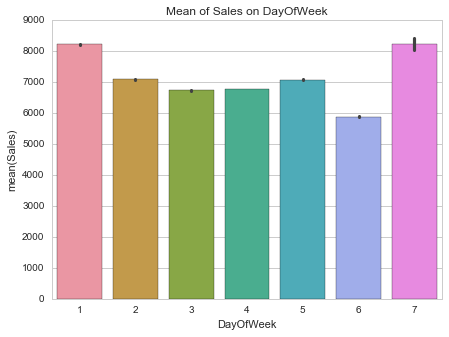

In [39]:
fig,(axis1)=plt.subplots(1,1,figsize=(7,5))
sns.barplot(x='DayOfWeek',y='Sales',data=train_raw_df.loc[train_raw_df.Open==1],order=[1,2,3,4,5,6,7],ax=axis1).set_title("Mean of Sales on DayOfWeek")


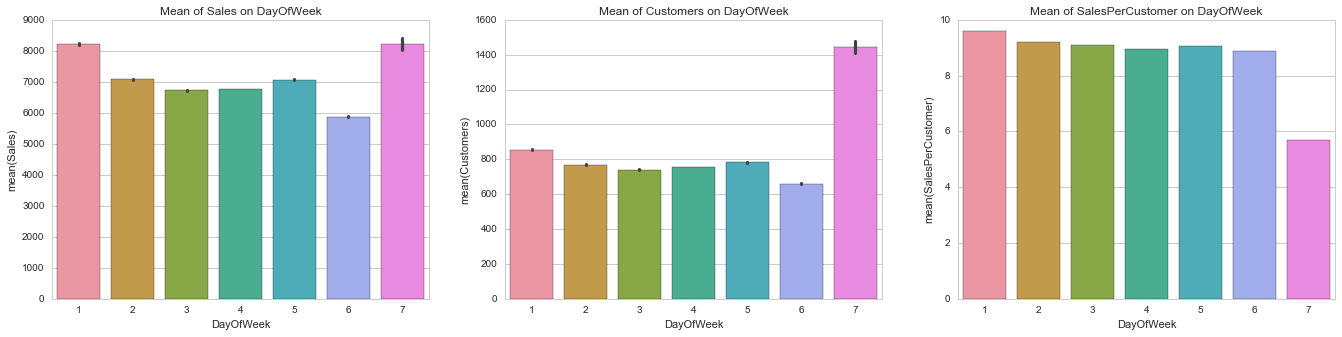

In [40]:
# mean of Sales,Customers,SalesPerCustomer on DayOfWeek(Only the open==1 is calculated)
fig,(axis1,axis2,axis3)=plt.subplots(1,3,figsize=(23,5))
sns.barplot(x='DayOfWeek',y='Sales',data=train_raw_df.loc[train_raw_df.Open==1],order=[1,2,3,4,5,6,7],ax=axis1).set_title("Mean of Sales on DayOfWeek")
sns.barplot(x='DayOfWeek',y='Customers',data=train_raw_df.loc[train_raw_df.Open==1],order=[1,2,3,4,5,6,7],ax=axis2).set_title("Mean of Customers on DayOfWeek")

#calc the SalesPerCustomer
temp=(train_raw_df.loc[train_raw_df.Open==1])[['Sales','Customers','DayOfWeek']].groupby('DayOfWeek').sum()
temp['SalesPerCustomer']=temp['Sales']/temp['Customers']
sns.barplot(x=temp.index,y='SalesPerCustomer',data=temp,order=[1,2,3,4,5,6,7],ax=axis3).set_title("Mean of SalesPerCustomer on DayOfWeek")

### 2.3 Sales,Customers,SalesPerCustomer on Promo

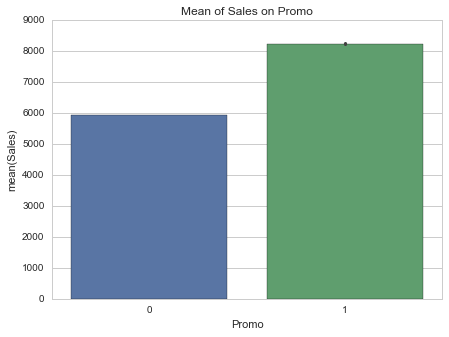

In [41]:
# Sales,Customers on Promo vs Non-Promo
fig,(axis1)=plt.subplots(1,1,figsize=(7,5))
sns.barplot(x='Promo',y='Sales',data=train_raw_df[train_raw_df.Open==1],order=[0,1],ax=axis1).set_title("Mean of Sales on Promo")

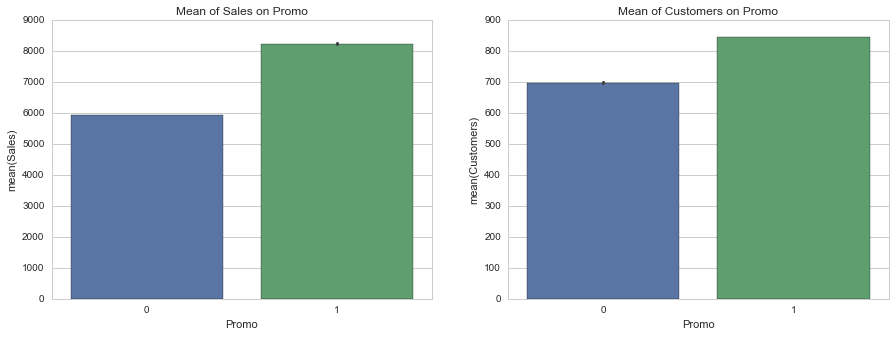

In [42]:
# Sales,Customers on Promo vs Non-Promo
fig,(axis1,axis2)=plt.subplots(1,2,figsize=(15,5))
sns.barplot(x='Promo',y='Sales',data=train_raw_df[train_raw_df.Open==1],order=[0,1],ax=axis1).set_title("Mean of Sales on Promo")
sns.barplot(x='Promo',y='Customers',data=train_raw_df[train_raw_df.Open==1],order=[0,1],ax=axis2).set_title("Mean of Customers on Promo")

(array([0, 1]), <a list of 2 Text xticklabel objects>)

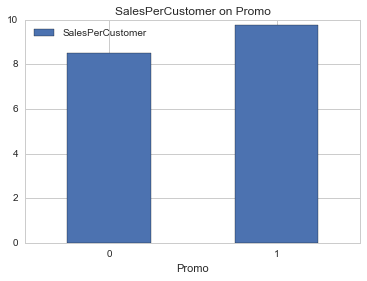

In [43]:
# SalesPerCustomers on Promo vs Non-Promo
temp=(train_raw_df.loc[train_raw_df.Open==1])[['Sales','Customers','Promo']].groupby('Promo').sum()
temp['SalesPerCustomer']=temp['Sales']/temp['Customers']
temp.plot(kind='bar', x=temp.index,y='SalesPerCustomer',title='SalesPerCustomer on Promo')
plt.xticks(rotation='horizontal')

### 2.4 Count of StateHoliday & Average Sales/Customers of StateHoliday 

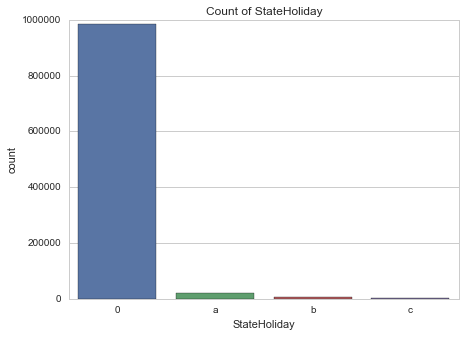

In [44]:
fig,(axis1)=plt.subplots(1,1,figsize=(7,5))

#Count of StateHoliday
sns.countplot(x='StateHoliday',data=train_raw_df,ax=axis1).set_title("Count of StateHoliday")

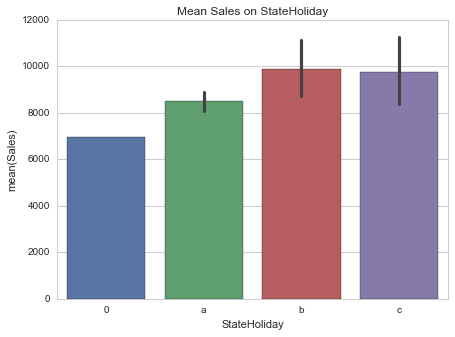

In [45]:
fig,(axis1)=plt.subplots(1,1,figsize=(7,5))


#Average Sales of StateHoliday 
mask=(train_raw_df['Open']==1)
sns.barplot(x='StateHoliday',y='Sales',data=train_raw_df[mask],ax=axis1).set_title("Mean Sales on StateHoliday")


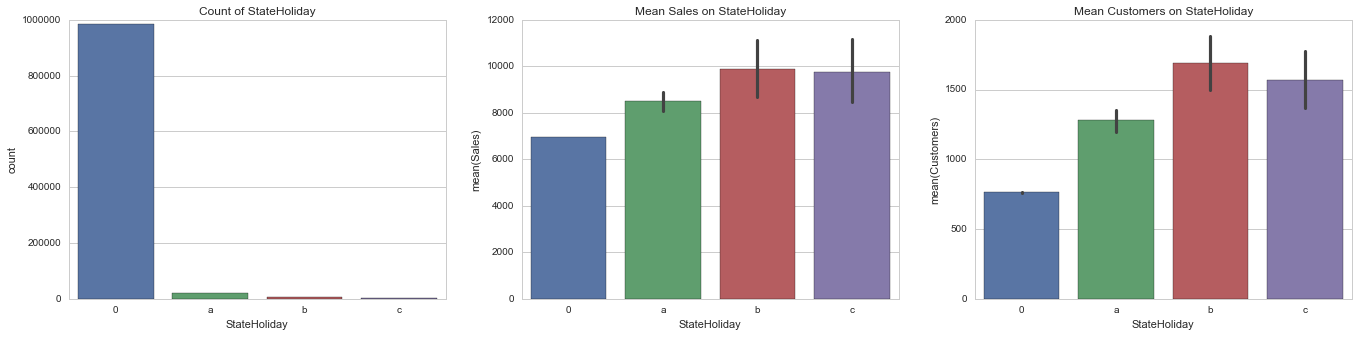

In [46]:
fig,(axis1,axis2,axis3)=plt.subplots(1,3,figsize=(23,5))

#Count of StateHoliday
sns.countplot(x='StateHoliday',data=train_raw_df,ax=axis1).set_title("Count of StateHoliday")

#Average Sales of StateHoliday 
mask=(train_raw_df['Open']==1)
sns.barplot(x='StateHoliday',y='Sales',data=train_raw_df[mask],ax=axis2).set_title("Mean Sales on StateHoliday")
sns.barplot(x='StateHoliday',y='Customers',data=train_raw_df[mask],ax=axis3).set_title("Mean Customers on StateHoliday")

### 2.5 Count of SchoolHoliday & Average Sales/Customers of SchoolHoliday 

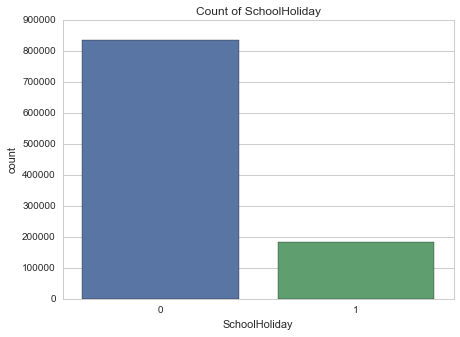

In [47]:
fig,(axis1)=plt.subplots(1,1,figsize=(7,5))

#Count of SchoolHoliday
sns.countplot(x='SchoolHoliday',data=train_raw_df,ax=axis1).set_title("Count of SchoolHoliday")

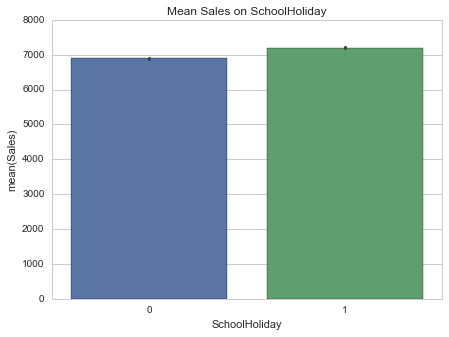

In [48]:
fig,(axis2)=plt.subplots(1,1,figsize=(7,5))


#Average Sales of SchoolHoliday 
mask=(train_raw_df['Open']==1)
sns.barplot(x='SchoolHoliday',y='Sales',data=train_raw_df[mask],ax=axis2).set_title("Mean Sales on SchoolHoliday")


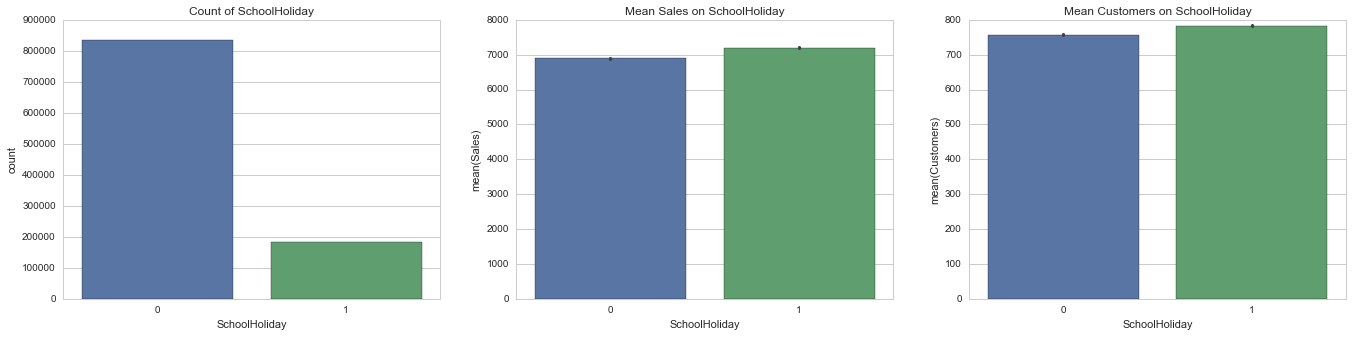

In [49]:
fig,(axis1,axis2,axis3)=plt.subplots(1,3,figsize=(23,5))

#Count of SchoolHoliday
sns.countplot(x='SchoolHoliday',data=train_raw_df,ax=axis1).set_title("Count of SchoolHoliday")

#Average Sales of SchoolHoliday 
mask=(train_raw_df['Open']==1)
sns.barplot(x='SchoolHoliday',y='Sales',data=train_raw_df[mask],ax=axis2).set_title("Mean Sales on SchoolHoliday")
sns.barplot(x='SchoolHoliday',y='Customers',data=train_raw_df[mask],ax=axis3).set_title("Mean Customers on SchoolHoliday")

### 2.6 Sales/Customers distribution & change over time

#### 2.6.1 Sales/Customers distribution

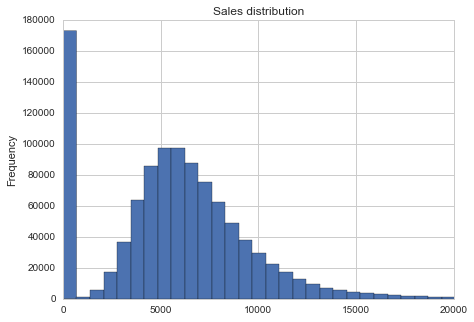

In [50]:
fig,(axis1)=plt.subplots(1,1,figsize=(7,5))
#Sales
_ =train_raw_df['Sales'].plot(kind='hist',bins=60,xlim=(0,20000),ax=axis1,title='Sales distribution')


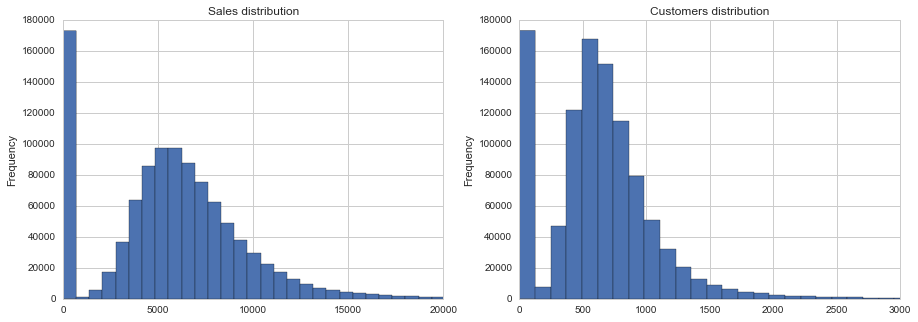

In [51]:
fig,(axis1,axis2)=plt.subplots(1,2,figsize=(15,5))
#Sales
_ =train_raw_df['Sales'].plot(kind='hist',bins=60,xlim=(0,20000),ax=axis1,title='Sales distribution')
#Customers
_ =train_raw_df['Customers'].plot(kind='hist',bins=60,xlim=(0,3000),ax=axis2,title='Customers distribution')

#### 2.6.2 Boxplot of Sales/Customers

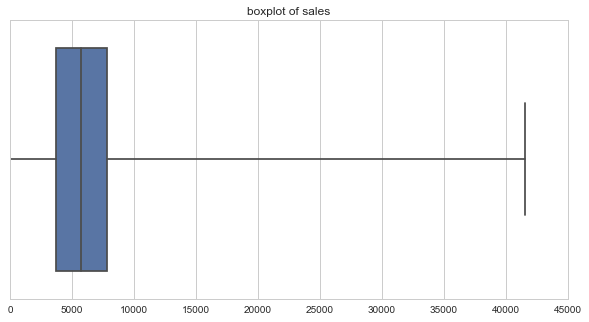

In [52]:
# plot boxplot of sales
fig,(axis1)=plt.subplots(1,1,figsize=(10,5))
_ =sns.boxplot([train_raw_df['Sales']],whis=np.inf,ax=axis1).set_title('boxplot of sales')


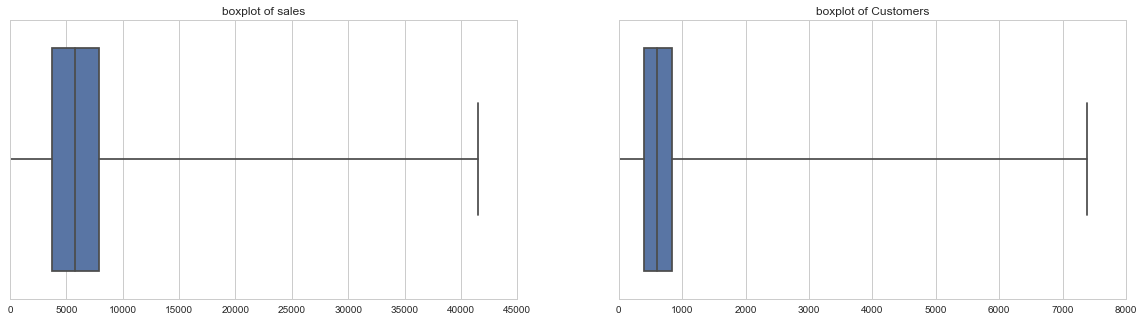

In [71]:
# plot boxplot of sales
fig,(axis1,axis2)=plt.subplots(1,2,figsize=(20,5))
_ =sns.boxplot([train_raw_df['Sales']],whis=np.inf,ax=axis1).set_title('boxplot of sales')
_ =sns.boxplot([train_raw_df['Customers']],whis=np.inf,ax=axis2).set_title('boxplot of Customers')

#### 2.6.3 Sales/Customer Average over year

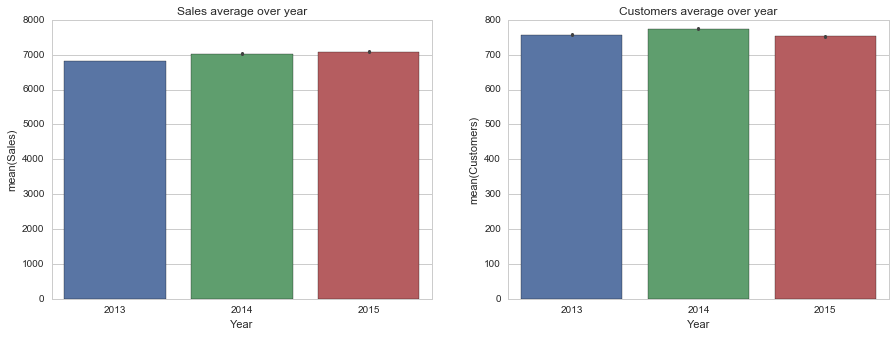

In [53]:
fig,(axis1,axis2)=plt.subplots(1,2,figsize=(15,5))

mask=(train_raw_df['Open']==1)
_ =sns.barplot(x='Year',y='Sales',data=train_raw_df[mask],ax=axis1).set_title("Sales average over year")

_ =sns.barplot(x='Year',y='Customers',data=train_raw_df[mask],ax=axis2).set_title("Customers average over year")

#### 2.6.4 Sales over month

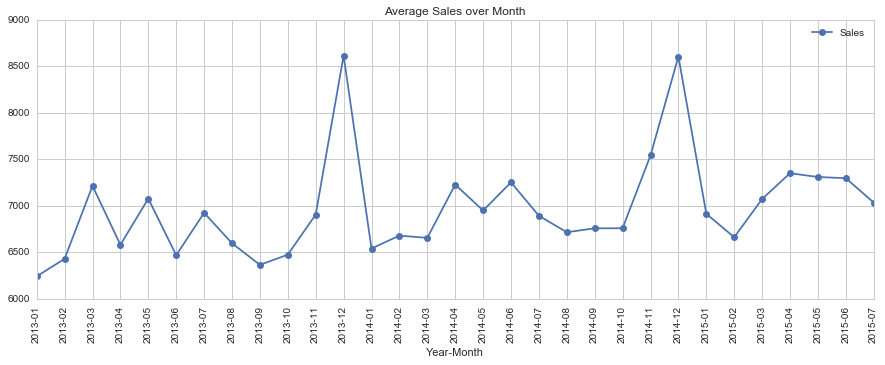

In [54]:
#Group by Year-Month and get average sales and percent change
mask=(train_raw_df['Open']==1)
average_sales=train_raw_df[mask].groupby('Year-Month')['Sales'].mean()
pct_change_sales=train_raw_df[mask].groupby('Year-Month')['Sales'].sum().pct_change()

fig,(axis1)=plt.subplots(1,1,sharex=True,figsize=(15,5))

#plot average sales over time(year-month)
ax1=average_sales.plot(legend=True,ax=axis1,marker='o',title='Average Sales over Month')
ax1.set_xticks(range(len(average_sales)))
ax1.set_xticklabels(average_sales.index.tolist(),rotation=90)



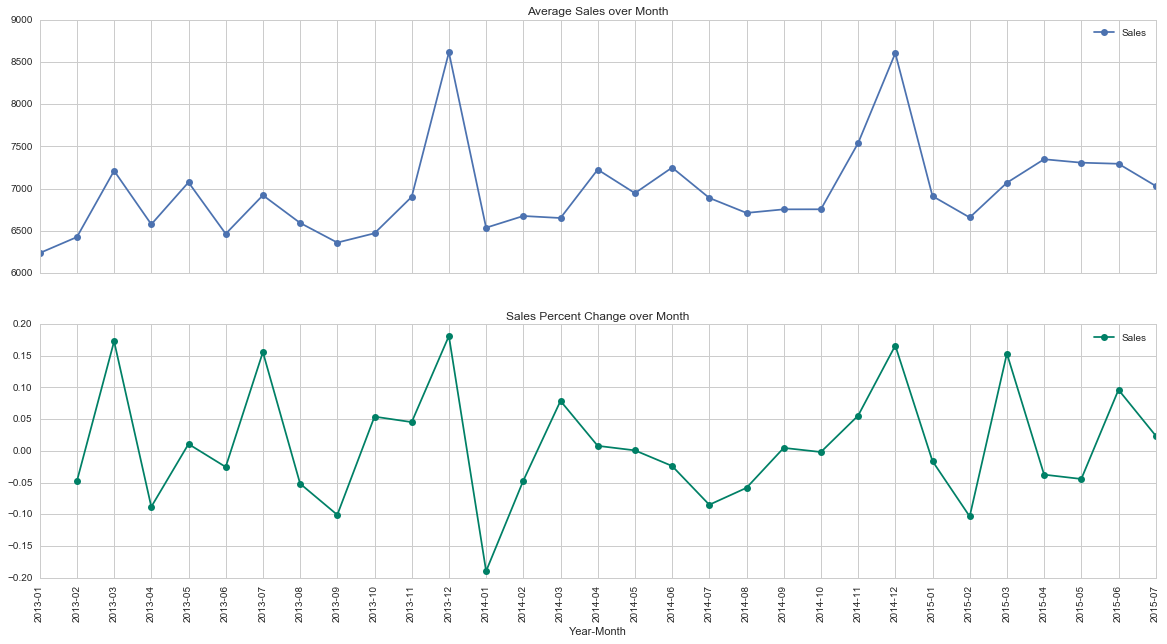

In [72]:
#Group by Year-Month and get average sales and percent change
mask=(train_raw_df['Open']==1)
average_sales=train_raw_df[mask].groupby('Year-Month')['Sales'].mean()
pct_change_sales=train_raw_df[mask].groupby('Year-Month')['Sales'].sum().pct_change()

fig,(axis1,axis2)=plt.subplots(2,1,sharex=True,figsize=(20,10))

#plot average sales over time(year-month)
ax1=average_sales.plot(legend=True,ax=axis1,marker='o',title='Average Sales over Month')
ax1.set_xticks(range(len(average_sales)))
ax1.set_xticklabels(average_sales.index.tolist(),rotation=90)

#plot percent change for sales over time
ax2=pct_change_sales.plot(legend=True,ax=axis2,marker='o',rot=90,colormap='summer',title='Sales Percent Change over Month')


#### 2.6.5 Customers over month

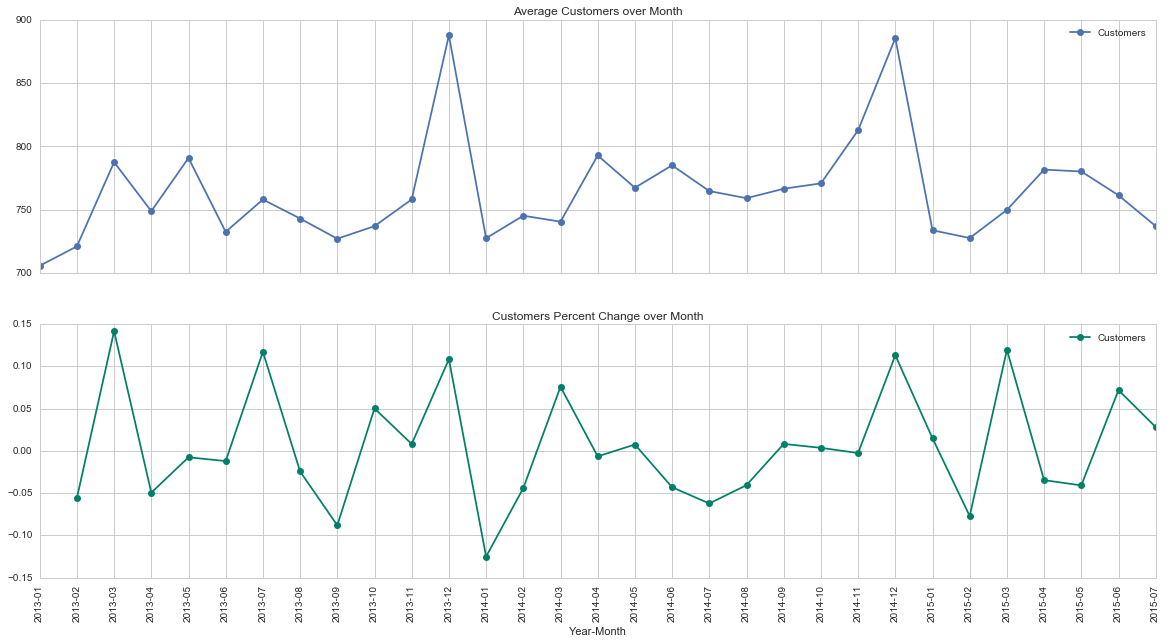

In [55]:
#Group by Year-Month and get average sales and percent change
mask=(train_raw_df['Open']==1)
average_customers=train_raw_df[mask].groupby('Year-Month')['Customers'].mean()
pct_change_customers=train_raw_df[mask].groupby('Year-Month')['Customers'].sum().pct_change()

fig,(axis1,axis2)=plt.subplots(2,1,sharex=True,figsize=(20,10))

#plot average sales over time(year-month)
ax1=average_customers.plot(legend=True,ax=axis1,marker='o',title='Average Customers over Month')
ax1.set_xticks(range(len(average_customers)))
ax1.set_xticklabels(average_customers.index.tolist(),rotation=90)

#plot percent change for sales over time
ax2=pct_change_customers.plot(legend=True,ax=axis2,marker='o',rot=90,colormap='summer',title='Customers Percent Change over Month')


### 2.7 StoreType: count & average sales/customers

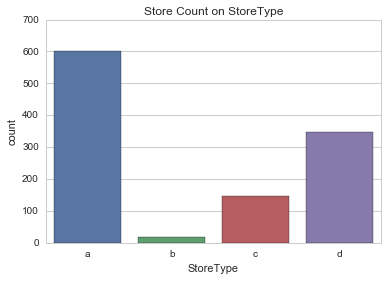

In [56]:
#count of StoreType
_ =sns.countplot(x='StoreType',order=['a','b','c','d'],data=store_raw_df).set_title('Store Count on StoreType')


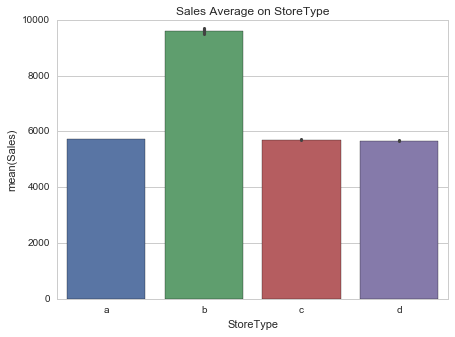

In [57]:
# average sales/customers on StoreType
fig,(axis1)=plt.subplots(1,1,figsize=(7,5))
mask=(train_raw_df['Open']==1)
sns.barplot(x='StoreType',y='Sales',data=train_store_raw_df[mask],order=['a','b','c','d'],ax=axis1).set_title('Sales Average on StoreType')


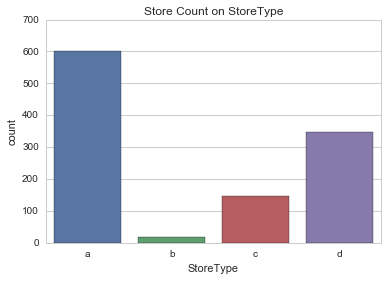

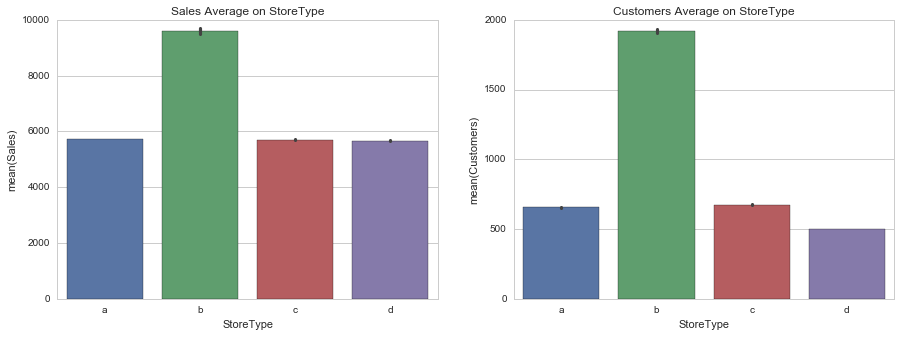

In [70]:
#count of StoreType
_ =sns.countplot(x='StoreType',order=['a','b','c','d'],data=store_raw_df).set_title('Store Count on StoreType')
# average sales/customers on StoreType
fig,(axis1,axis2)=plt.subplots(1,2,figsize=(15,5))
mask=(train_raw_df['Open']==1)
sns.barplot(x='StoreType',y='Sales',data=train_store_raw_df[mask],order=['a','b','c','d'],ax=axis1).set_title('Sales Average on StoreType')
sns.barplot(x='StoreType',y='Customers',data=train_store_raw_df[mask],order=['a','b','c','d'],ax=axis2).set_title('Customers Average on StoreType')

### 2.8 Assortment: count & average sales/customers

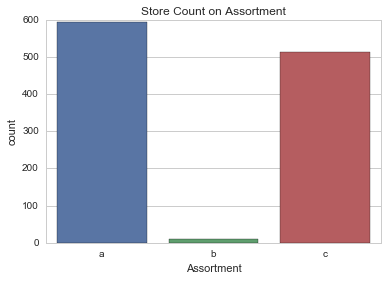

In [58]:
#count of Assortment
_ =sns.countplot(x='Assortment',order=['a','b','c'],data=store_raw_df).set_title('Store Count on Assortment')


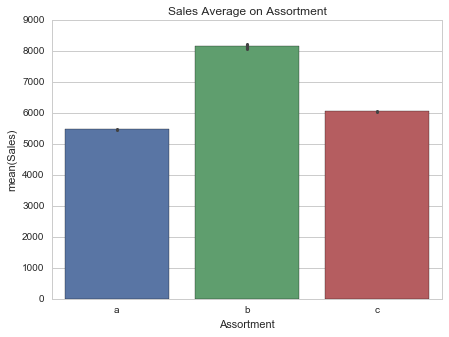

In [59]:
fig,(axis1)=plt.subplots(1,1,figsize=(7,5))
mask=(train_raw_df['Open']==1)
sns.barplot(x='Assortment',y='Sales',data=train_store_raw_df[mask],order=['a','b','c'],ax=axis1).set_title('Sales Average on Assortment')


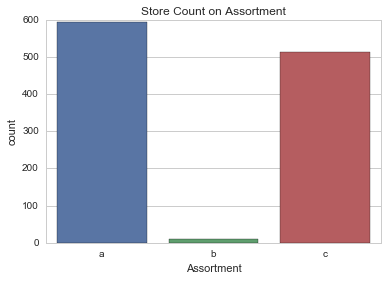

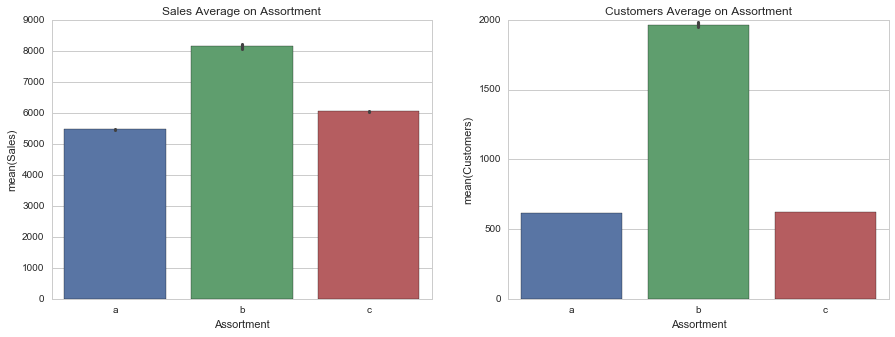

In [60]:
#count of Assortment
_ =sns.countplot(x='Assortment',order=['a','b','c'],data=store_raw_df).set_title('Store Count on Assortment')
# average sales/customers on Assortment
fig,(axis1,axis2)=plt.subplots(1,2,figsize=(15,5))
mask=(train_raw_df['Open']==1)
sns.barplot(x='Assortment',y='Sales',data=train_store_raw_df[mask],order=['a','b','c'],ax=axis1).set_title('Sales Average on Assortment')
sns.barplot(x='Assortment',y='Customers',data=train_store_raw_df[mask],order=['a','b','c'],ax=axis2).set_title('Customers Average on Assortment')

### 2.9 Competition: 
#### 2.9.1 Competition Distance

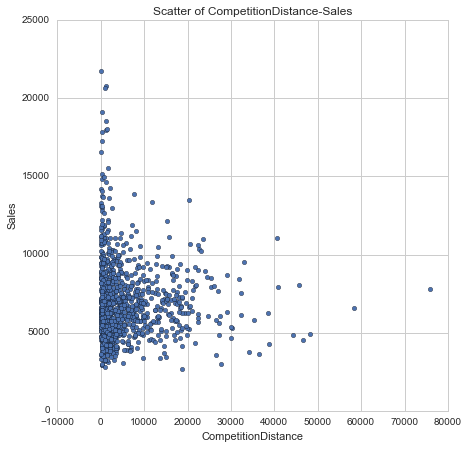

In [61]:
# Plot CompetitionDistance vs Sales
fig,(axis1)=plt.subplots(1,1,figsize=(10,10))
mask=(train_store_raw_df['Open']==1)&(train_store_raw_df['InCompetitionToday']==1)
temp=(train_store_raw_df.loc[mask,['Store','Sales','CompetitionDistance']]).groupby('Store').mean()
temp.plot(kind='scatter',x='CompetitionDistance',y='Sales',figsize=(7,7),ax=axis1).set_title('Scatter of CompetitionDistance-Sales')

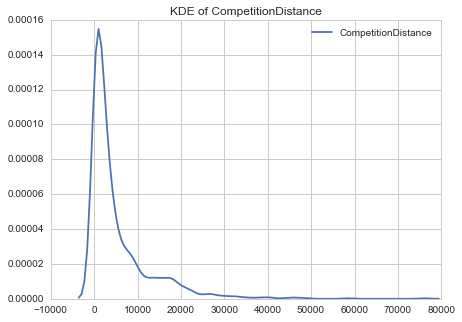

In [62]:
# Plot CompetitionDistance vs Sales
fig,(axis2)=plt.subplots(1,1,figsize=(7,5))
mask=(train_store_raw_df['Open']==1)&(train_store_raw_df['InCompetitionToday']==1)
temp=(train_store_raw_df.loc[mask,['Store','Sales','CompetitionDistance']]).groupby('Store').mean()


sns.kdeplot(temp['CompetitionDistance'],ax=axis2).set_title('KDE of CompetitionDistance')


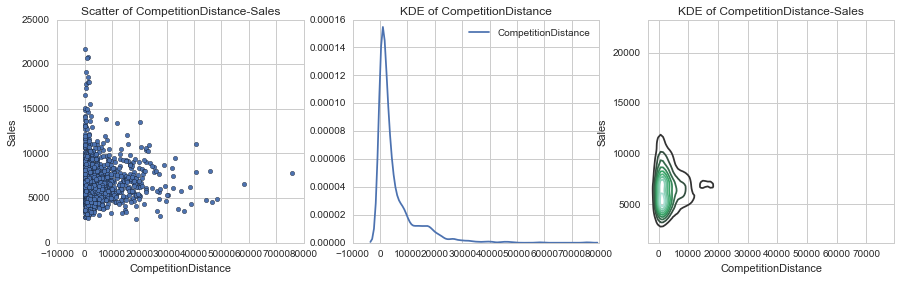

In [63]:
# Plot CompetitionDistance vs Sales
fig,(axis1,axis2,axis3)=plt.subplots(1,3,figsize=(23,5))
mask=(train_store_raw_df['Open']==1)&(train_store_raw_df['InCompetitionToday']==1)
temp=(train_store_raw_df.loc[mask,['Store','Sales','CompetitionDistance']]).groupby('Store').mean()
temp.plot(kind='scatter',x='CompetitionDistance',y='Sales',figsize=(15,4),ax=axis1).set_title('Scatter of CompetitionDistance-Sales')

sns.kdeplot(temp['CompetitionDistance'],ax=axis2).set_title('KDE of CompetitionDistance')
sns.kdeplot(temp['CompetitionDistance'],temp['Sales'],ax=axis3).set_title('KDE of CompetitionDistance-Sales')

#### 2.9.2 the Competition's effect on Sales

In [64]:
# 挑选出Competition出现在train数据时间段范围内
mask=(train_store_raw_df.CompetitionSinceDate>train_store_raw_df.Date_time.min())&(train_store_raw_df.CompetitionSinceDate<train_store_raw_df.Date_time.max())
temp_store_list=train_store_raw_df[mask].Store.unique()
temp_store_list

array([   5,    6,    7,    8,   14,   28,   30,   33,   37,   45,   47,
         51,   52,   53,   54,   57,   75,   84,   95,  103,  106,  110,
        116,  120,  122,  126,  131,  133,  137,  138,  159,  166,  169,
        170,  181,  185,  189,  191,  197,  213,  214,  219,  221,  225,
        230,  246,  249,  261,  262,  263,  264,  266,  268,  269,  270,
        275,  276,  280,  286,  301,  304,  315,  317,  318,  321,  326,
        336,  347,  355,  361,  369,  375,  380,  386,  391,  395,  403,
        413,  416,  423,  428,  432,  447,  449,  452,  461,  488,  489,
        490,  496,  506,  513,  518,  523,  524,  525,  539,  550,  551,
        555,  556,  560,  563,  578,  581,  585,  595,  598,  599,  601,
        604,  608,  626,  629,  630,  635,  646,  647,  653,  661,  675,
        677,  683,  685,  706,  715,  718,  730,  740,  745,  752,  770,
        774,  784,  788,  800,  801,  810,  814,  819,  828,  837,  839,
        859,  872,  878,  882,  901,  902,  903,  9

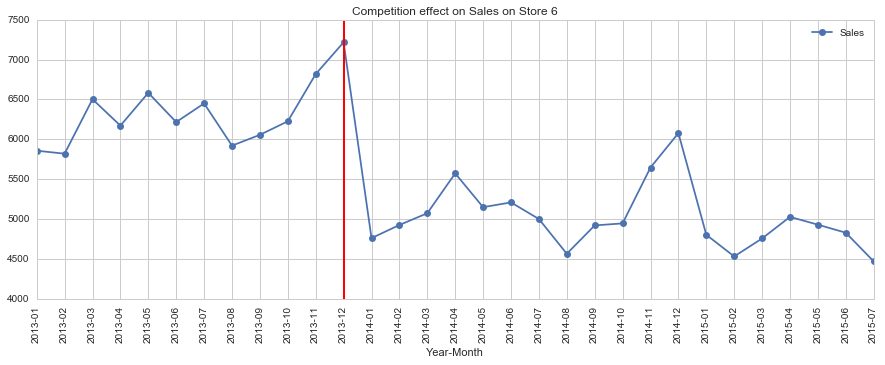

In [65]:
# 挑出三个store_id，并绘制出销售额Sales与Competition的关系
picked_order=[1]
picked_store=list (temp_store_list[i] for i in picked_order)
mask=(train_store_raw_df['Open']==1)
for ii in picked_store:
    mask=(train_store_raw_df['Open']==1)&(train_store_raw_df['Store']==ii)
    store_id_data=train_store_raw_df.loc[mask]
    store_sell_data=store_id_data[['Year-Month','Sales']].groupby('Year-Month')['Sales'].mean()
    ax1=store_sell_data.plot(legend=True,marker='o',title='Competition effect on Sales on Store {}'.format(ii),figsize=(15,5))
    _=ax1.set_xticks(range(len(store_sell_data)) )
    _=ax1.set_xticklabels(store_sell_data.index.tolist(),rotation=90)
    # Get year and month when competition started
    m=store_id_data.CompetitionOpenSinceMonth.values[0]
    y=store_id_data.CompetitionOpenSinceYear.values[0]

    plt.axvline(x=(y-2013)*12+(m-1),linewidth=2,color='red')
    plt.show()

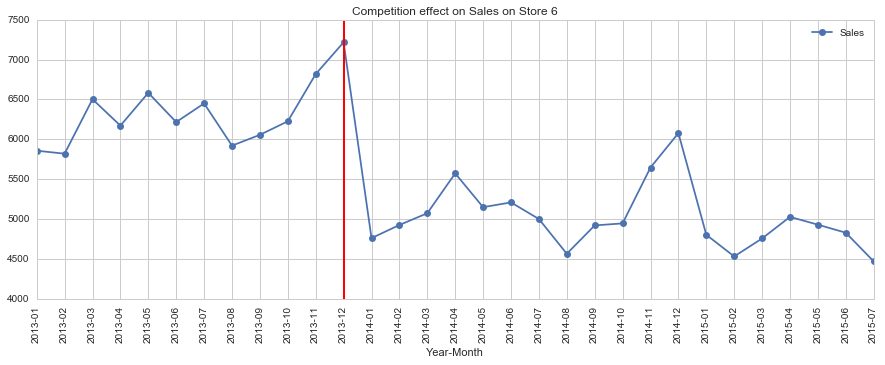

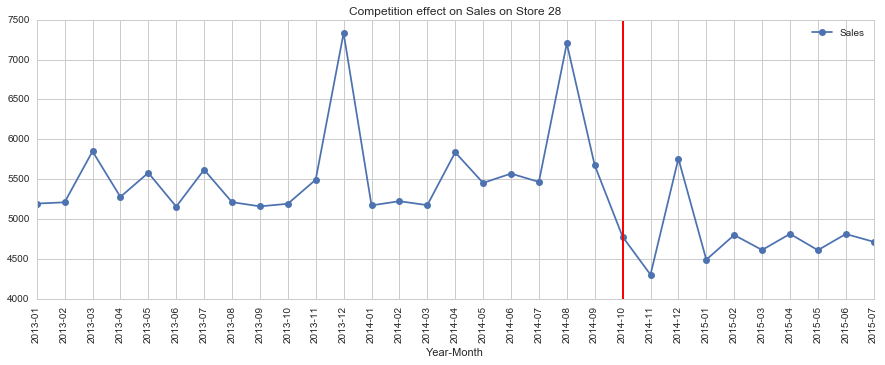

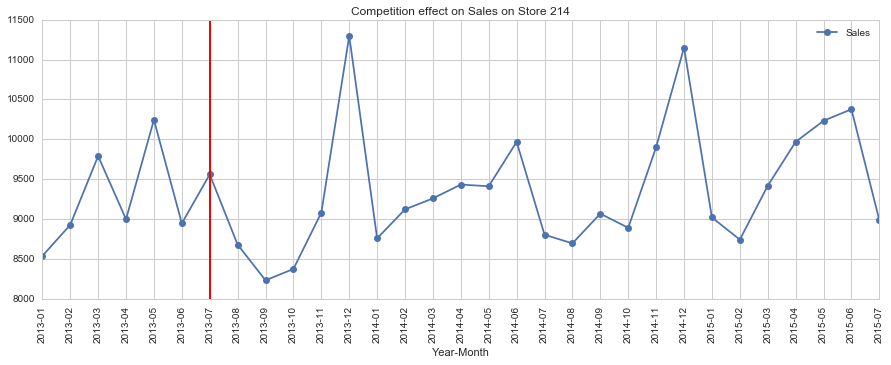

In [66]:
# 挑出三个store_id，并绘制出销售额Sales与Competition的关系
picked_order=[1,5,40]
picked_store=list (temp_store_list[i] for i in picked_order)
mask=(train_store_raw_df['Open']==1)
for ii in picked_store:
    mask=(train_store_raw_df['Open']==1)&(train_store_raw_df['Store']==ii)
    store_id_data=train_store_raw_df.loc[mask]
    store_sell_data=store_id_data[['Year-Month','Sales']].groupby('Year-Month')['Sales'].mean()
    ax1=store_sell_data.plot(legend=True,marker='o',title='Competition effect on Sales on Store {}'.format(ii),figsize=(15,5))
    _=ax1.set_xticks(range(len(store_sell_data)) )
    _=ax1.set_xticklabels(store_sell_data.index.tolist(),rotation=90)
    # Get year and month when competition started
    m=store_id_data.CompetitionOpenSinceMonth.values[0]
    y=store_id_data.CompetitionOpenSinceYear.values[0]

    plt.axvline(x=(y-2013)*12+(m-1),linewidth=2,color='red')
    plt.show()

### 2.10 Promo2
#### 2.10.1 Sales/Customers on InPromo2Today

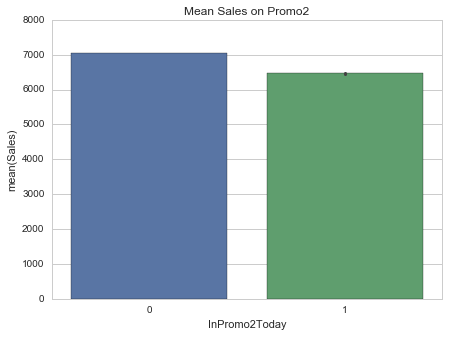

In [67]:
#为研究Promo2的影响，只选取那些Promo2=1的store在Open=1,Promo2开始后的数据进行分析
mask=(train_store_raw_df['Open']==1)
fig,(axis1)=plt.subplots(1,1,figsize=(7,5))
sns.barplot(x='InPromo2Today',y='Sales',ax=axis1,data=train_store_raw_df[mask]).set_title('Mean Sales on Promo2')


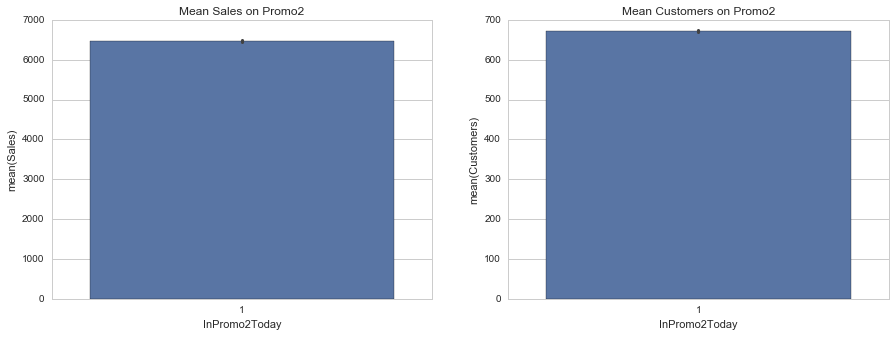

In [68]:
#为研究Promo2的影响，只选取那些Promo2=1的store在Open=1,Promo2开始后的数据进行分析
mask=(train_store_raw_df['Promo2']==1)&(train_store_raw_df['DaysCountSincePromo2']>0)&(train_store_raw_df['Open']==1)
fig,(axis1,axis2)=plt.subplots(1,2,figsize=(15,5))
sns.barplot(x='InPromo2Today',y='Sales',ax=axis1,data=train_store_raw_df[mask]).set_title('Mean Sales on Promo2')
sns.barplot(x='InPromo2Today',y='Customers',ax=axis2,data=train_store_raw_df[mask]).set_title('Mean Customers on Promo2')

#### 2.10.2 Sales/Customers on Promo2 

/Users/pengjuzhao/anaconda/lib/python2.7/site-packages/matplotlib/lines.py:545: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markevery != every:


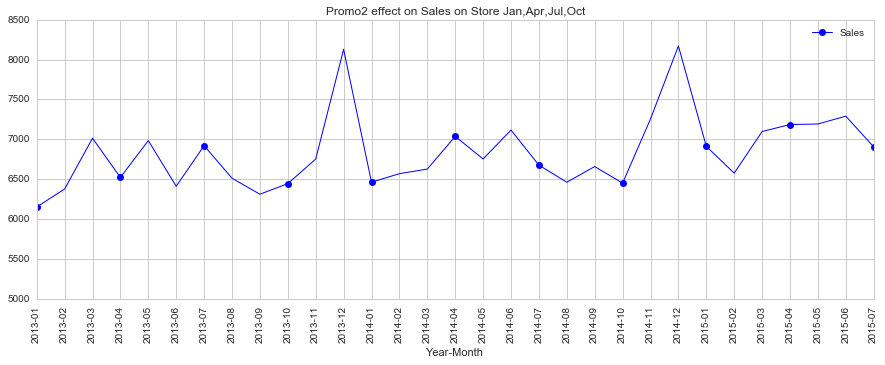

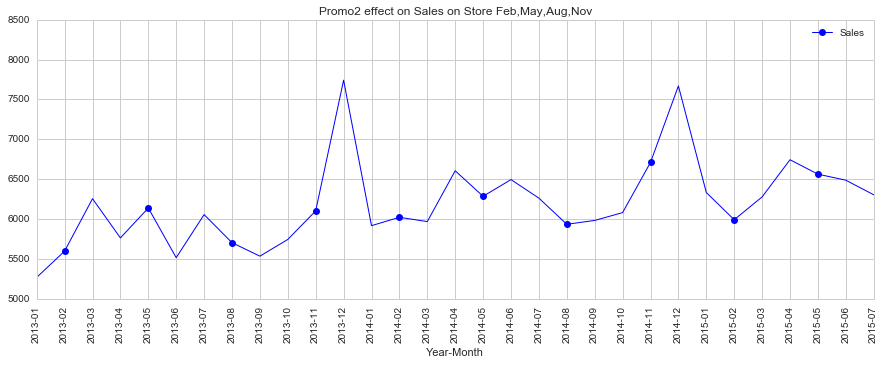

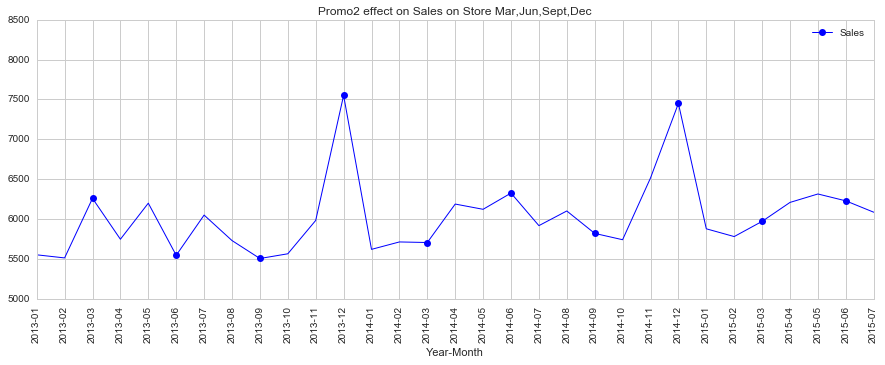

In [69]:
#选取那些Promo2SinceDate在train开始前之前的数据进行分析
mask1=(pd.to_datetime(train_store_raw_df.Promo2SinceDate)>train_store_raw_df.Date_time.min()
     )&(train_store_raw_df.Open==1)&(train_store_raw_df.Promo2==1)
Interval=train_store_raw_df['PromoInterval'].unique()

mon_map={
    'Jan,Apr,Jul,Oct':0,
    'Feb,May,Aug,Nov':1,
    'Mar,Jun,Sept,Dec':2
  }
for ii in Interval:
    if ii!='':
        fig,(axis1)=plt.subplots(1,1,figsize=(15,5))
        mask=mask1&(train_store_raw_df['PromoInterval']==ii)
        temp=train_store_raw_df.loc[mask][['Year-Month','Sales']].groupby('Year-Month').mean()
        
        x_list=range(len(store_sell_data))
        markers_on=np.array(x_list)[np.mod(x_list,3)==mon_map[ii]]
        ax1=temp.plot(linestyle='-', marker='o', color='b',linewidth=1,legend=True,markevery=markers_on,title='Promo2 effect on Sales on Store {}'.format(ii),ax=axis1,ylim=[5000,8500])
        _=ax1.set_xticks(range(len(store_sell_data)) )
        _=ax1.set_xticklabels(store_sell_data.index.tolist(),rotation=90)
                
        plt.show()
        


## 3. 训练基准模型

###  3.0 将处理好的数据从本地硬盘读入

In [73]:
file_train_store_raw_df='train_store_raw_df.pickle'

file_feature='feature_x_list.pickle'
path='Capstone_Project_Rossman_Sales_Prediction_1'


train_store_raw_df=pd.read_pickle(os.path.join(path, file_train_store_raw_df))

feature_x_list=pd.read_pickle(os.path.join(path, file_feature)).tolist()

### 3.1 从train_store_raw_df数据集中划分出：训练集、验证集和测试集，基准模型将基于验证集进行度量
- 用2015-04-22之前的数据作为训练集
- 将5周(2015-05-23到2015-06-26)的数据作为验证集
- 将最后5周(2015-06-27到2015-07-31)的数据作为测试集

In [103]:
mask_train=train_store_raw_df['Date']<='2015-05-22'
mask_valid=(train_store_raw_df['Date']>'2015-05-22') & (train_store_raw_df['Date']<='2015-06-26' )
mask_test=train_store_raw_df['Date']>'2015-06-26'


train_store_df=train_store_raw_df[mask_train]
valid_store_df=train_store_raw_df[mask_valid]
test_store_df=train_store_raw_df[mask_test]


benchmark_train_df=train_store_df.copy()
benchmark_valid_store_df=valid_store_df.copy()
benchmark_test_store_df=test_store_df.copy()


### 3.2 挑选出最优的特征组合训练基准模型

#### 3.2.1  训练基准模型
- 基准模型采用具有相同特征参数数据子集的中位数；
- 采用的特征包含药店编号、星期几，月份、是否促销、当天是否促销2等；
- 将特征组合与对应RMSPE存到dict features_RMSPE

#### 3.2.2 对验证集进行测试
- 利用选好的特征，训练出基准模型
- 将model结果以dict形式进行保存，以便于高效计算
- 使用训练好的基准模型对验证集进行测试：applymap方法可以非常高效地求出映射结果

#### 3.2.3 定义评估函数
本项目采用Kaggle比赛的评估指标：RMSPE（误差百分比的均方差），可表示为
$$
RMSPE= \sqrt{\frac{1}{n}\sum_{i=1}^{n}(\frac{y_i-\hat{y_i}}{y_i})^2}
$$
其中，任何当天销售额为0的数据在评估时将被忽略； $y_i$ 表示某药店在某天的实际销售额，而$\hat{y_i}$ 表示该药店在对应这一天的预测销售额。

#### 3.2.4 求出基准模型在验证集上的RMSPE

In [104]:
#使用训练好的基准模型对验证集进行测试：applymap方法可以非常高效地求出映射结果
def predict_benchmark_model(df,features,map_dict):
    mask_0=df['Open']==0
    mask_1=df['Open']!=0
    df.loc[mask_0,'Sales_Predicted']=0
    df['tuple_map']=df[features].apply(tuple,axis=1)
    df.loc[mask_1,'Sales_Predicted']=df.loc[mask_1,'tuple_map'].map(map_dict)
    return df

#定义评估函数
def calc_RMSPE(input_df,true_label='Sales',predicted_label='Sales_Predicted'):
    mask=input_df[true_label]>0
    sale=input_df.loc[mask,[true_label,predicted_label]]
    sale['errror']=np.power((sale[true_label]-sale[predicted_label])/sale[true_label],2.0)
    return np.sqrt(np.sum(sale['errror'])/(len(sale)))

#采用的特征包含药店编号、星期几，月份、是否促销、当天是否促销2等；
features_benchmark=(['Store','DayOfWeek','Promo','Month','InPromo2Today'])
#将特征组合与对应RMSPE存到dict features_RMSPE
features_RMSPE={}

#提取出所有可能的特征组合放入subset
for L in range(2, len(features_benchmark)+1):
    for subset in itertools.combinations(features_benchmark, L):
        valid_df=benchmark_valid_store_df.copy()
        
        features=list(subset)
        features_sales=features+['Sales']
        
        #利用选好的特征，训练出基准模型
        benchmark_model=train_store_df[train_store_df['Open']==1][features_sales].groupby(features).median()
        #将model结果以dict形式进行保存，以便于高效计算
        benchmark_model_dict=benchmark_model['Sales'].to_dict()
        
        valid_df= predict_benchmark_model(valid_df,features,benchmark_model_dict)   
        RMSPE_valid_benchmark=calc_RMSPE(valid_df)
        features_RMSPE[subset]=RMSPE_valid_benchmark

#### 3.2.5 打印在验证集上features_RMSPE中数值较小的三个

In [105]:
#打印features_RMSPE中数值较小的三个
sorted_RMSPE = sorted(features_RMSPE.items(), key=operator.itemgetter(1))
print("-----------RMSPE较小的三个特征组合与在对应验证集的RMSPE-------------")
for ii in range(3):
    print sorted_RMSPE[ii][0],':',sorted_RMSPE[ii][1]

-----------RMSPE较小的三个特征组合与在对应验证集的RMSPE-------------
('Store', 'DayOfWeek', 'Promo', 'InPromo2Today') : 0.14381319557
('Store', 'DayOfWeek', 'Promo') : 0.144778435827
('Store', 'DayOfWeek', 'Promo', 'Month', 'InPromo2Today') : 0.151216526324


### 3.3 利用验证集验证结果挑选最佳特征组合，并训练基准模型，最后在测试集进行预测

In [106]:
benchmark_train_df= predict_benchmark_model(benchmark_train_df,features_benchmark,benchmark_model_dict)   
RMSPE_train_benchmark=calc_RMSPE(benchmark_train_df)
print('基准模型在训练集上的RMSPE:{:.6f}'.format(RMSPE_train_benchmark))


基准模型在训练集上的RMSPE:0.216497


In [107]:
features_benchmark=list(min(features_RMSPE, key=features_RMSPE.get))
features_benchmark_sales=features_benchmark+['Sales']

#利用选好的特征，训练出基准模型
benchmark_model=train_store_df[train_store_df['Open']==1][features_benchmark_sales].groupby(features_benchmark).median()
#将model结果以dict形式进行保存，以便于高效计算
benchmark_model_dict=benchmark_model['Sales'].to_dict()
        
valid_df=benchmark_valid_store_df.copy()    
valid_df= predict_benchmark_model(valid_df,features_benchmark,benchmark_model_dict)   
RMSPE_valid_benchmark=calc_RMSPE(valid_df)
print('基准模型在验证集上的RMSPE:{:.6f}'.format(RMSPE_valid_benchmark))

test_df=benchmark_test_store_df.copy()
test_df= predict_benchmark_model(test_df,features_benchmark,benchmark_model_dict)   
RMSPE_test_benchmark=calc_RMSPE(test_df)
print('基准模型在测试集上的RMSPE:{:.6f}'.format(RMSPE_test_benchmark))



基准模型在验证集上的RMSPE:0.143813
基准模型在测试集上的RMSPE:0.150210


mean=828.7
median=596.5
max=20704.0
min=0.0
sum=27807594.5


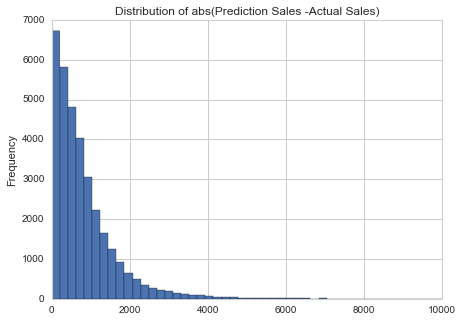

In [108]:
mask=test_df['Open']==1
y_diff=np.abs((test_df['Sales']-test_df['Sales_Predicted'])[mask])
print 'mean={:.1f}'.format(y_diff.mean())
print 'median={:.1f}'.format(y_diff.median())
print 'max={:.1f}'.format(y_diff.max())
print 'min={:.1f}'.format(y_diff.min())
print 'sum={:.1f}'.format(y_diff.sum())
fig,(axis1)=plt.subplots(1,1,figsize=(7,5))
#Sales
_ =y_diff.plot(kind='hist',bins=100,xlim=(0,10000),ax=axis1,title='Distribution of abs(Prediction Sales -Actual Sales)')

## 4. 构建XGBoost初始模型，并预测结果


###  4.0数据读入及预处理
#### 4.0.1 将处理好的数据从本地硬盘读入

In [109]:
file_train_store_raw_df='train_store_raw_df.pickle'
file_feature='feature_x_list.pickle'
path='Capstone_Project_Rossman_Sales_Prediction_1'

train_store_raw_df=pd.read_pickle(os.path.join(path, file_train_store_raw_df))
feature_x_list=pd.read_pickle(os.path.join(path, file_feature)).tolist()

#### 4.0.2 每个特征所对应的unique数值
- dict_feature_range：每个feature所对应的范围
- dict_feature_offset：每个feature最小值移到0所对应的offset

In [110]:
dict_feature_range={}
dict_feature_offset={}

for ii in feature_x_list:
    unique_list=train_store_raw_df[ii].unique()
    max_v=max(unique_list)
    min_v=min(unique_list)
    dict_feature_range[ii]=(int)(max_v-min_v+1)
    dict_feature_offset[ii]=(int)(min_v)
    print '{0: <30}'.format(ii),':','unique=','{0: <5}'.format(len(unique_list)),\
    ',max=','{0: <5}'.format((max_v)),',min=','{0: <5}'.format((min_v)), \
    ',range=','{0: <5}'.format((dict_feature_range[ii])),',offset=','{0: <5}'.format((dict_feature_offset[ii]))


Store                          : unique= 1115  ,max= 1115  ,min= 1     ,range= 1115  ,offset= 1    
DayOfWeek                      : unique= 7     ,max= 7     ,min= 1     ,range= 7     ,offset= 1    
Year                           : unique= 3     ,max= 2015  ,min= 2013  ,range= 3     ,offset= 2013 
Month                          : unique= 12    ,max= 12    ,min= 1     ,range= 12    ,offset= 1    
Day                            : unique= 31    ,max= 31    ,min= 1     ,range= 31    ,offset= 1    
DayOfYear                      : unique= 365   ,max= 365   ,min= 1     ,range= 365   ,offset= 1    
StoreType_cat                  : unique= 4     ,max= 3     ,min= 0     ,range= 4     ,offset= 0    
Assortment_cat                 : unique= 3     ,max= 2     ,min= 0     ,range= 3     ,offset= 0    
StateHoliday_cat               : unique= 4     ,max= 3     ,min= 0     ,range= 4     ,offset= 0    
SchoolHoliday                  : unique= 2     ,max= 1     ,min= 0     ,range= 2     ,offset= 0    


#### 4.0.3 将数据对应feature_x_list每列添加offset，将数据的最小值设为0

In [111]:
modified_train_store_raw_df=train_store_raw_df.copy()

for col in feature_x_list:
    modified_train_store_raw_df[col]=modified_train_store_raw_df[col]-dict_feature_offset[col]
    
for ii in feature_x_list:
    unique_list=modified_train_store_raw_df[ii].unique()
    max_v=max(unique_list)
    min_v=min(unique_list)
    print '{0: <30}'.format(ii),':','unique=','{0: <5}'.format(len(unique_list)),\
    ',max=','{0: <5}'.format((max_v)),',min=','{0: <5}'.format((min_v)), \
    ',range=','{0: <5}'.format((int)(max_v-min_v+1)),',offset=','{0: <5}'.format((int)(min_v))    

Store                          : unique= 1115  ,max= 1114  ,min= 0     ,range= 1115  ,offset= 0    
DayOfWeek                      : unique= 7     ,max= 6     ,min= 0     ,range= 7     ,offset= 0    
Year                           : unique= 3     ,max= 2     ,min= 0     ,range= 3     ,offset= 0    
Month                          : unique= 12    ,max= 11    ,min= 0     ,range= 12    ,offset= 0    
Day                            : unique= 31    ,max= 30    ,min= 0     ,range= 31    ,offset= 0    
DayOfYear                      : unique= 365   ,max= 364   ,min= 0     ,range= 365   ,offset= 0    
StoreType_cat                  : unique= 4     ,max= 3     ,min= 0     ,range= 4     ,offset= 0    
Assortment_cat                 : unique= 3     ,max= 2     ,min= 0     ,range= 3     ,offset= 0    
StateHoliday_cat               : unique= 4     ,max= 3     ,min= 0     ,range= 4     ,offset= 0    
SchoolHoliday                  : unique= 2     ,max= 1     ,min= 0     ,range= 2     ,offset= 0    


#### 4.0.4 构造train_df数据，valid_df数据

In [112]:
mask_train=(modified_train_store_raw_df['Date']<='2015-05-22') &(modified_train_store_raw_df['Outlier_3']==False) \
            & (modified_train_store_raw_df['Open']==1) & (modified_train_store_raw_df['Sales']>0)
mask_valid=(modified_train_store_raw_df['Date']>'2015-05-22')&(modified_train_store_raw_df['Date']<='2015-06-26' )  \
            & (modified_train_store_raw_df['Open']==1)\
            & (modified_train_store_raw_df['Sales']>0)
mask_valid=(modified_train_store_raw_df['Date']>'2015-06-26')  \
            & (modified_train_store_raw_df['Open']==1)\
            & (modified_train_store_raw_df['Sales']>0)

    
    
df_train=modified_train_store_raw_df.loc[mask_train,feature_x_list]
df_valid=modified_train_store_raw_df.loc[mask_valid,feature_x_list]
df_test=modified_train_store_raw_df.loc[mask_test,feature_x_list]

y_train_data=np.array(modified_train_store_raw_df.loc[mask_train,'Sales'])
y_valid_data=np.array(modified_train_store_raw_df.loc[mask_valid,'Sales'])
y_test_data=np.array(modified_train_store_raw_df.loc[mask_test,'Sales'])

#### 4.0.5 构造XGBoost模型所需要的train, valid数据

In [113]:
X_train,X_valid,X_test=df_train,df_valid,df_test
y_train=modified_train_store_raw_df.loc[mask_train,'SalesLog']
y_valid=modified_train_store_raw_df.loc[mask_valid,'SalesLog']
y_test=modified_train_store_raw_df.loc[mask_test,'SalesLog']

#### 4.0.6 验证valid数据中每个feature是否有不包含在train数据中的unique数值

In [114]:
for ii in feature_x_list:
    set_unique_train=set(df_train[ii].unique())
    set_unique_valid=set(df_valid[ii].unique())

    
    if set_unique_train.issuperset(set_unique_valid):
        print '{0: <30}'.format(ii),'= 1'
    else:
        print '{0: <30}'.format(ii),'= 0'

Store                          = 1
DayOfWeek                      = 1
Year                           = 1
Month                          = 1
Day                            = 1
DayOfYear                      = 1
StoreType_cat                  = 1
Assortment_cat                 = 1
StateHoliday_cat               = 1
SchoolHoliday                  = 1
Promo                          = 1
Promo2                         = 1
InPromo2Today                  = 1
DaysCountSinceCompetition_log  = 1
InCompetition                  = 1
InCompetitionToday             = 1
CompetitionDistance_log        = 1
DaysCountSincePromo2_log       = 1


### 4.1 设置XGBoost的初始学习率eta和其他待优化参数的初始值

In [115]:
print('training data processed')

learning_rate=0.1
params = {    
         'max_depth':6,
         'min_child_weight':1,
         'gamma':0,
         'subsample':0.8,
         'colsample_bytree':0.8,    

         'eta':learning_rate,    
         'silent':1, 
         'objective':'reg:linear',
         'seed':seed_1}

num_boost_round=20000
early_stopping_round=int(10/learning_rate)

start_time = time.time()
dtrain=xgb.DMatrix(X_train[feature_x_list],y_train)
dvalid=xgb.DMatrix(X_valid[feature_x_list],y_valid)

def rmspe(y,yhat):
    return np.sqrt(np.mean((yhat/y-1)**2))
def rmspe_xg(yhat,y):
    y=np.expm1(y.get_label())
    yhat=np.expm1(yhat)
    return 'rmspe',rmspe(y,yhat)

watchlist=[(dtrain,'train'),(dvalid,'eval')]
gbm_0=xgb.train(params,dtrain,num_boost_round,evals=watchlist,early_stopping_rounds=early_stopping_round,feval=rmspe_xg,verbose_eval=False)
print("--- %s seconds ---" % (time.time() - start_time))

training data processed


Will train until eval error hasn't decreased in 100 rounds.


--- 1478.98960495 seconds ---


Stopping. Best iteration:
[1698]	train-rmspe:0.134391	eval-rmspe:0.157130



### 4.3 使用训练模型预测验证集 & 保存模型

In [116]:
print('Validating')
yhat=gbm_0.predict(xgb.DMatrix(X_valid[feature_x_list]))
error=rmspe(np.exp(y_valid),np.exp(yhat))
print('XGBoost模型在验证集上的RMSPE:{:.6f}'.format(error))


Validating
XGBoost模型在验证集上的RMSPE:0.157274


### 4.4 显示训练模型的重要性

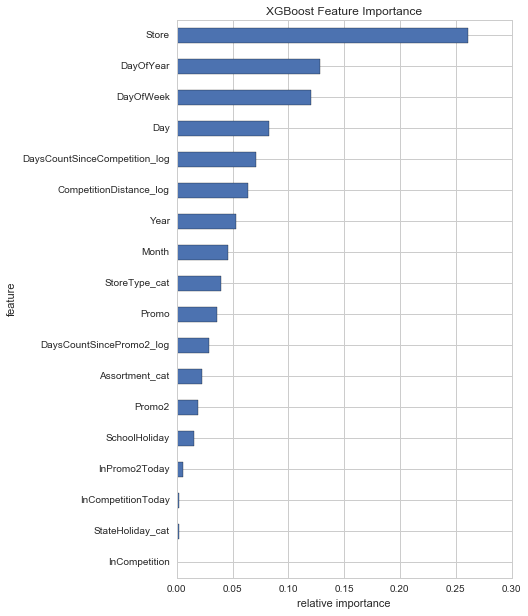

In [86]:
# XGB feature importances
# Based on https://www.kaggle.com/mmueller/liberty-mutual-group-property-inspection-prediction/xgb-feature-importance-python/code
features=feature_x_list
def create_feature_map(features):
    outfile=open('xgb.fmap','w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i,feat))
    outfile.close()
create_feature_map(features)
importance=gbm_0.get_fscore(fmap='xgb.fmap')
importance=sorted(importance.items(),key=operator.itemgetter(1))

df=pd.DataFrame(importance,columns=['feature','fscore'])
df['fscore']=df['fscore']/df['fscore'].sum()

featp=df.plot(kind='barh',x='feature',y='fscore',legend=False,figsize=(6,10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')

### 4.5 优化learning rate 
- 选择0.3

In [92]:
print('training data processed')

learning_rate=0.5
params = {    
         'max_depth':6,
         'min_child_weight':1,
         'gamma':0,
         'subsample':0.8,
         'colsample_bytree':0.8,    

         'eta':learning_rate,    
         'silent':1, 
         'objective':'reg:linear',
         'seed':seed_1}

num_boost_round=20000
early_stopping_round=int(10/learning_rate)

start_time = time.time()
dtrain=xgb.DMatrix(X_train[feature_x_list],y_train)
dvalid=xgb.DMatrix(X_valid[feature_x_list],y_valid)

def rmspe(y,yhat):
    return np.sqrt(np.mean((yhat/y-1)**2))
def rmspe_xg(yhat,y):
    y=np.expm1(y.get_label())
    yhat=np.expm1(yhat)
    return 'rmspe',rmspe(y,yhat)

watchlist=[(dtrain,'train'),(dvalid,'eval')]
gbm_1=xgb.train(params,dtrain,num_boost_round,evals=watchlist,early_stopping_rounds=early_stopping_round,feval=rmspe_xg,verbose_eval=False)
print("--- %s seconds ---" % (time.time() - start_time))

training data processed


Will train until eval error hasn't decreased in 20 rounds.
[0]	train-rmspe:0.982797	eval-rmspe:0.983546
[1]	train-rmspe:0.866156	eval-rmspe:0.870876
[2]	train-rmspe:0.638975	eval-rmspe:0.643866
[3]	train-rmspe:0.440699	eval-rmspe:0.440134
[4]	train-rmspe:0.361871	eval-rmspe:0.345891
[5]	train-rmspe:0.359711	eval-rmspe:0.335967
[6]	train-rmspe:0.365261	eval-rmspe:0.337605
[7]	train-rmspe:0.369654	eval-rmspe:0.340723
[8]	train-rmspe:0.365920	eval-rmspe:0.336118
[9]	train-rmspe:0.364723	eval-rmspe:0.333270
[10]	train-rmspe:0.353991	eval-rmspe:0.323670
[11]	train-rmspe:0.350889	eval-rmspe:0.320944
[12]	train-rmspe:0.343602	eval-rmspe:0.314968
[13]	train-rmspe:0.342346	eval-rmspe:0.313701
[14]	train-rmspe:0.339101	eval-rmspe:0.311134
[15]	train-rmspe:0.332344	eval-rmspe:0.303469
[16]	train-rmspe:0.331304	eval-rmspe:0.303118
[17]	train-rmspe:0.326493	eval-rmspe:0.298297
[18]	train-rmspe:0.321099	eval-rmspe:0.293247
[19]	train-rmspe:0.318245	eval-rmspe:0.290661
[20]	train-rmspe:0.312935	eval-

--- 265.597778082 seconds ---


[339]	train-rmspe:0.145992	eval-rmspe:0.138945
Stopping. Best iteration:
[319]	train-rmspe:0.146683	eval-rmspe:0.138833



In [93]:
print('Validating')
yhat=gbm_1.predict(xgb.DMatrix(X_valid[feature_x_list]))
error=rmspe(np.exp(y_valid),np.exp(yhat))
print('XGBoost模型在验证集上的RMSPE:{:.6f}'.format(error))


Validating
XGBoost模型在验证集上的RMSPE:0.138914


In [94]:
print('training data processed')

learning_rate=0.25
params = {    
         'max_depth':6,
         'min_child_weight':1,
         'gamma':0,
         'subsample':0.8,
         'colsample_bytree':0.8,    

         'eta':learning_rate,    
         'silent':1, 
         'objective':'reg:linear',
         'seed':seed_1}

num_boost_round=20000
early_stopping_round=int(10/learning_rate)

start_time = time.time()
dtrain=xgb.DMatrix(X_train[feature_x_list],y_train)
dvalid=xgb.DMatrix(X_valid[feature_x_list],y_valid)

def rmspe(y,yhat):
    return np.sqrt(np.mean((yhat/y-1)**2))
def rmspe_xg(yhat,y):
    y=np.expm1(y.get_label())
    yhat=np.expm1(yhat)
    return 'rmspe',rmspe(y,yhat)

watchlist=[(dtrain,'train'),(dvalid,'eval')]
gbm_2=xgb.train(params,dtrain,num_boost_round,evals=watchlist,early_stopping_rounds=early_stopping_round,feval=rmspe_xg,verbose_eval=False)
print("--- %s seconds ---" % (time.time() - start_time))

training data processed


Will train until eval error hasn't decreased in 40 rounds.
[0]	train-rmspe:0.997942	eval-rmspe:0.998033
[1]	train-rmspe:0.989775	eval-rmspe:0.990195
[2]	train-rmspe:0.967219	eval-rmspe:0.968496
[3]	train-rmspe:0.922102	eval-rmspe:0.925125
[4]	train-rmspe:0.851714	eval-rmspe:0.857034
[5]	train-rmspe:0.761182	eval-rmspe:0.768477
[6]	train-rmspe:0.661521	eval-rmspe:0.669517
[7]	train-rmspe:0.564998	eval-rmspe:0.572105
[8]	train-rmspe:0.482685	eval-rmspe:0.487379
[9]	train-rmspe:0.419503	eval-rmspe:0.419222
[10]	train-rmspe:0.379751	eval-rmspe:0.372002
[11]	train-rmspe:0.355875	eval-rmspe:0.341918
[12]	train-rmspe:0.347915	eval-rmspe:0.328435
[13]	train-rmspe:0.348535	eval-rmspe:0.324721
[14]	train-rmspe:0.351352	eval-rmspe:0.324055
[15]	train-rmspe:0.353295	eval-rmspe:0.325321
[16]	train-rmspe:0.358353	eval-rmspe:0.332888
[17]	train-rmspe:0.357602	eval-rmspe:0.331045
[18]	train-rmspe:0.359880	eval-rmspe:0.332961
[19]	train-rmspe:0.360716	eval-rmspe:0.334112
[20]	train-rmspe:0.361533	eval-

--- 1193.16522717 seconds ---


[1537]	train-rmspe:0.102455	eval-rmspe:0.126519
Stopping. Best iteration:
[1497]	train-rmspe:0.103402	eval-rmspe:0.125283



In [95]:
print('Validating')
yhat=gbm_2.predict(xgb.DMatrix(X_valid[feature_x_list]))
error=rmspe(np.exp(y_valid),np.exp(yhat))
print('XGBoost模型在验证集上的RMSPE:{:.6f}'.format(error))


Validating
XGBoost模型在验证集上的RMSPE:0.126492


In [96]:
print('training data processed')

learning_rate=0.3
params = {    
         'max_depth':6,
         'min_child_weight':1,
         'gamma':0,
         'subsample':0.8,
         'colsample_bytree':0.8,    

         'eta':learning_rate,    
         'silent':1, 
         'objective':'reg:linear',
         'seed':seed_1}

num_boost_round=20000
early_stopping_round=int(10/learning_rate)

start_time = time.time()
dtrain=xgb.DMatrix(X_train[feature_x_list],y_train)
dvalid=xgb.DMatrix(X_valid[feature_x_list],y_valid)

def rmspe(y,yhat):
    return np.sqrt(np.mean((yhat/y-1)**2))
def rmspe_xg(yhat,y):
    y=np.expm1(y.get_label())
    yhat=np.expm1(yhat)
    return 'rmspe',rmspe(y,yhat)

watchlist=[(dtrain,'train'),(dvalid,'eval')]
gbm_3=xgb.train(params,dtrain,num_boost_round,evals=watchlist,early_stopping_rounds=early_stopping_round,feval=rmspe_xg,verbose_eval=False)
print("--- %s seconds ---" % (time.time() - start_time))

training data processed


Will train until eval error hasn't decreased in 33 rounds.
[0]	train-rmspe:0.996810	eval-rmspe:0.996950
[1]	train-rmspe:0.981323	eval-rmspe:0.982076
[2]	train-rmspe:0.937339	eval-rmspe:0.939462
[3]	train-rmspe:0.855050	eval-rmspe:0.858842
[4]	train-rmspe:0.741698	eval-rmspe:0.746863
[5]	train-rmspe:0.618240	eval-rmspe:0.624093
[6]	train-rmspe:0.507553	eval-rmspe:0.510930
[7]	train-rmspe:0.424345	eval-rmspe:0.423195
[8]	train-rmspe:0.374704	eval-rmspe:0.362161
[9]	train-rmspe:0.353524	eval-rmspe:0.333484
[10]	train-rmspe:0.350115	eval-rmspe:0.325047
[11]	train-rmspe:0.349651	eval-rmspe:0.321100
[12]	train-rmspe:0.356669	eval-rmspe:0.325243
[13]	train-rmspe:0.355298	eval-rmspe:0.321906
[14]	train-rmspe:0.356522	eval-rmspe:0.323721
[15]	train-rmspe:0.358311	eval-rmspe:0.324548
[16]	train-rmspe:0.360192	eval-rmspe:0.328939
[17]	train-rmspe:0.362080	eval-rmspe:0.330795
[18]	train-rmspe:0.359609	eval-rmspe:0.329454
[19]	train-rmspe:0.354626	eval-rmspe:0.324150
[20]	train-rmspe:0.352970	eval-

--- 777.178956985 seconds ---


[996]	train-rmspe:0.121598	eval-rmspe:0.125593
Stopping. Best iteration:
[963]	train-rmspe:0.123284	eval-rmspe:0.125382



In [97]:
print('Validating')
yhat=gbm_3.predict(xgb.DMatrix(X_valid[feature_x_list]))
error=rmspe(np.exp(y_valid),np.exp(yhat))
print('XGBoost模型在验证集上的RMSPE:{:.6f}'.format(error))


Validating
XGBoost模型在验证集上的RMSPE:0.125566


In [98]:
print('training data processed')

learning_rate=0.35
params = {    
         'max_depth':6,
         'min_child_weight':1,
         'gamma':0,
         'subsample':0.8,
         'colsample_bytree':0.8,    

         'eta':learning_rate,    
         'silent':1, 
         'objective':'reg:linear',
         'seed':seed_1}

num_boost_round=20000
early_stopping_round=int(10/learning_rate)

start_time = time.time()
dtrain=xgb.DMatrix(X_train[feature_x_list],y_train)
dvalid=xgb.DMatrix(X_valid[feature_x_list],y_valid)

def rmspe(y,yhat):
    return np.sqrt(np.mean((yhat/y-1)**2))
def rmspe_xg(yhat,y):
    y=np.expm1(y.get_label())
    yhat=np.expm1(yhat)
    return 'rmspe',rmspe(y,yhat)

watchlist=[(dtrain,'train'),(dvalid,'eval')]
gbm_4=xgb.train(params,dtrain,num_boost_round,evals=watchlist,early_stopping_rounds=early_stopping_round,feval=rmspe_xg,verbose_eval=False)
print("--- %s seconds ---" % (time.time() - start_time))

training data processed


Will train until eval error hasn't decreased in 28 rounds.
[0]	train-rmspe:0.995102	eval-rmspe:0.995318
[1]	train-rmspe:0.967403	eval-rmspe:0.968653
[2]	train-rmspe:0.890519	eval-rmspe:0.893173
[3]	train-rmspe:0.762248	eval-rmspe:0.766839
[4]	train-rmspe:0.613185	eval-rmspe:0.616516
[5]	train-rmspe:0.483746	eval-rmspe:0.484214
[6]	train-rmspe:0.399427	eval-rmspe:0.390026
[7]	train-rmspe:0.360108	eval-rmspe:0.342944
[8]	train-rmspe:0.352839	eval-rmspe:0.330479
[9]	train-rmspe:0.358305	eval-rmspe:0.332396
[10]	train-rmspe:0.362013	eval-rmspe:0.334880
[11]	train-rmspe:0.366693	eval-rmspe:0.338602
[12]	train-rmspe:0.371669	eval-rmspe:0.341528
[13]	train-rmspe:0.375307	eval-rmspe:0.344868
[14]	train-rmspe:0.370638	eval-rmspe:0.340271
[15]	train-rmspe:0.365751	eval-rmspe:0.335851
[16]	train-rmspe:0.361161	eval-rmspe:0.330645
[17]	train-rmspe:0.356172	eval-rmspe:0.326645
[18]	train-rmspe:0.350715	eval-rmspe:0.320874
[19]	train-rmspe:0.346198	eval-rmspe:0.315809
[20]	train-rmspe:0.344309	eval-

--- 292.309969187 seconds ---


[375]	train-rmspe:0.159351	eval-rmspe:0.142178
Stopping. Best iteration:
[347]	train-rmspe:0.162237	eval-rmspe:0.142172



In [99]:
print('Validating')
yhat=gbm_4.predict(xgb.DMatrix(X_valid[feature_x_list]))
error=rmspe(np.exp(y_valid),np.exp(yhat))
print('XGBoost模型在验证集上的RMSPE:{:.6f}'.format(error))


Validating
XGBoost模型在验证集上的RMSPE:0.142147


In [100]:
print('training data processed')

learning_rate=0.45
params = {    
         'max_depth':6,
         'min_child_weight':1,
         'gamma':0,
         'subsample':0.8,
         'colsample_bytree':0.8,    

         'eta':learning_rate,    
         'silent':1, 
         'objective':'reg:linear',
         'seed':seed_1}

num_boost_round=20000
early_stopping_round=int(10/learning_rate)

start_time = time.time()
dtrain=xgb.DMatrix(X_train[feature_x_list],y_train)
dvalid=xgb.DMatrix(X_valid[feature_x_list],y_valid)

def rmspe(y,yhat):
    return np.sqrt(np.mean((yhat/y-1)**2))
def rmspe_xg(yhat,y):
    y=np.expm1(y.get_label())
    yhat=np.expm1(yhat)
    return 'rmspe',rmspe(y,yhat)

watchlist=[(dtrain,'train'),(dvalid,'eval')]
gbm_5=xgb.train(params,dtrain,num_boost_round,evals=watchlist,early_stopping_rounds=early_stopping_round,feval=rmspe_xg,verbose_eval=False)
print("--- %s seconds ---" % (time.time() - start_time))

training data processed


Will train until eval error hasn't decreased in 22 rounds.
[0]	train-rmspe:0.988646	eval-rmspe:0.989143
[1]	train-rmspe:0.912737	eval-rmspe:0.915911
[2]	train-rmspe:0.738277	eval-rmspe:0.740890
[3]	train-rmspe:0.537709	eval-rmspe:0.538274
[4]	train-rmspe:0.404406	eval-rmspe:0.397772
[5]	train-rmspe:0.360130	eval-rmspe:0.344726
[6]	train-rmspe:0.361397	eval-rmspe:0.339076
[7]	train-rmspe:0.370746	eval-rmspe:0.346036
[8]	train-rmspe:0.376791	eval-rmspe:0.350559
[9]	train-rmspe:0.381854	eval-rmspe:0.355733
[10]	train-rmspe:0.380134	eval-rmspe:0.355768
[11]	train-rmspe:0.380725	eval-rmspe:0.356483
[12]	train-rmspe:0.371244	eval-rmspe:0.347634
[13]	train-rmspe:0.361539	eval-rmspe:0.340169
[14]	train-rmspe:0.355484	eval-rmspe:0.333065
[15]	train-rmspe:0.346078	eval-rmspe:0.323402
[16]	train-rmspe:0.340116	eval-rmspe:0.319032
[17]	train-rmspe:0.337485	eval-rmspe:0.318142
[18]	train-rmspe:0.336170	eval-rmspe:0.316645
[19]	train-rmspe:0.331698	eval-rmspe:0.312457
[20]	train-rmspe:0.326466	eval-

--- 149.080572844 seconds ---


[180]	train-rmspe:0.170325	eval-rmspe:0.151675
Stopping. Best iteration:
[158]	train-rmspe:0.173982	eval-rmspe:0.151555



In [101]:
print('Validating')
yhat=gbm_5.predict(xgb.DMatrix(X_valid[feature_x_list]))
error=rmspe(np.exp(y_valid),np.exp(yhat))
print('XGBoost模型在验证集上的RMSPE:{:.6f}'.format(error))


Validating
XGBoost模型在验证集上的RMSPE:0.151644


### 4.5 优化 max_depth 和 min_child_weight
- max_depth可选范围 4 6 8 10
- min_child_weight可选范围 1 3 5

In [104]:
print('training data processed')
def rmspe(y,yhat):
    return np.sqrt(np.mean((yhat/y-1)**2))
def rmspe_xg(yhat,y):
    y=np.expm1(y.get_label())
    yhat=np.expm1(yhat)
    return 'rmspe',rmspe(y,yhat)


max_depth_dict=[4,6,8,10]
min_child_weight_dict=[1,3,5]
rmspe_dp_mcw={}
for max_depth in max_depth_dict:
    for min_child_weight in min_child_weight_dict:
        learning_rate=0.3
        params = {    
                 'max_depth':max_depth,
                 'min_child_weight':min_child_weight,
                 'gamma':0,
                 'subsample':0.8,
                 'colsample_bytree':0.8,    

                 'eta':learning_rate,    
                 'silent':1, 
                 'objective':'reg:linear',
                 'seed':seed_1}
        

        num_boost_round=20000
        early_stopping_round=int(10/learning_rate)

        start_time = time.time()
        dtrain=xgb.DMatrix(X_train[feature_x_list],y_train)
        dvalid=xgb.DMatrix(X_valid[feature_x_list],y_valid)


        watchlist=[(dtrain,'train'),(dvalid,'eval')]
        gbm_6=xgb.train(params,dtrain,num_boost_round,evals=watchlist,early_stopping_rounds=early_stopping_round,feval=rmspe_xg,verbose_eval=False)
        print("--- %s seconds ---" % (time.time() - start_time))
        #验证
        yhat=gbm_6.predict(xgb.DMatrix(X_valid[feature_x_list]))
        error=rmspe(np.exp(y_valid),np.exp(yhat))
        rmspe_dp_mcw[(max_depth,min_child_weight)]=error

training data processed


Will train until eval error hasn't decreased in 33 rounds.
[0]	train-rmspe:0.996804	eval-rmspe:0.996940
[1]	train-rmspe:0.981273	eval-rmspe:0.981983
[2]	train-rmspe:0.937129	eval-rmspe:0.939403
[3]	train-rmspe:0.854572	eval-rmspe:0.859415
[4]	train-rmspe:0.741215	eval-rmspe:0.748188
[5]	train-rmspe:0.618694	eval-rmspe:0.626555
[6]	train-rmspe:0.510096	eval-rmspe:0.515227
[7]	train-rmspe:0.431406	eval-rmspe:0.430698
[8]	train-rmspe:0.387471	eval-rmspe:0.376250
[9]	train-rmspe:0.366862	eval-rmspe:0.346953
[10]	train-rmspe:0.366651	eval-rmspe:0.338862
[11]	train-rmspe:0.373766	eval-rmspe:0.339952
[12]	train-rmspe:0.381244	eval-rmspe:0.342993
[13]	train-rmspe:0.387913	eval-rmspe:0.347242
[14]	train-rmspe:0.393460	eval-rmspe:0.350713
[15]	train-rmspe:0.397814	eval-rmspe:0.353062
[16]	train-rmspe:0.400827	eval-rmspe:0.359165
[17]	train-rmspe:0.401442	eval-rmspe:0.359783
[18]	train-rmspe:0.399646	eval-rmspe:0.357740
[19]	train-rmspe:0.400859	eval-rmspe:0.360789
[20]	train-rmspe:0.396805	eval-

--- 456.957106113 seconds ---


Will train until eval error hasn't decreased in 33 rounds.
[0]	train-rmspe:0.996804	eval-rmspe:0.996940
[1]	train-rmspe:0.981273	eval-rmspe:0.981983
[2]	train-rmspe:0.937129	eval-rmspe:0.939403
[3]	train-rmspe:0.854572	eval-rmspe:0.859415
[4]	train-rmspe:0.741215	eval-rmspe:0.748188
[5]	train-rmspe:0.618694	eval-rmspe:0.626555
[6]	train-rmspe:0.510096	eval-rmspe:0.515227
[7]	train-rmspe:0.431406	eval-rmspe:0.430698
[8]	train-rmspe:0.387471	eval-rmspe:0.376250
[9]	train-rmspe:0.366862	eval-rmspe:0.346953
[10]	train-rmspe:0.366651	eval-rmspe:0.338862
[11]	train-rmspe:0.373766	eval-rmspe:0.339952
[12]	train-rmspe:0.381244	eval-rmspe:0.342993
[13]	train-rmspe:0.387913	eval-rmspe:0.347242
[14]	train-rmspe:0.393460	eval-rmspe:0.350713
[15]	train-rmspe:0.397814	eval-rmspe:0.353062
[16]	train-rmspe:0.400827	eval-rmspe:0.359165
[17]	train-rmspe:0.401442	eval-rmspe:0.359783
[18]	train-rmspe:0.399646	eval-rmspe:0.357740
[19]	train-rmspe:0.400858	eval-rmspe:0.360789
[20]	train-rmspe:0.396805	eval-

--- 1095.9028821 seconds ---


Will train until eval error hasn't decreased in 33 rounds.
[0]	train-rmspe:0.996804	eval-rmspe:0.996940
[1]	train-rmspe:0.981273	eval-rmspe:0.981983
[2]	train-rmspe:0.937129	eval-rmspe:0.939403
[3]	train-rmspe:0.854572	eval-rmspe:0.859415
[4]	train-rmspe:0.741215	eval-rmspe:0.748188
[5]	train-rmspe:0.618694	eval-rmspe:0.626555
[6]	train-rmspe:0.510096	eval-rmspe:0.515227
[7]	train-rmspe:0.431406	eval-rmspe:0.430698
[8]	train-rmspe:0.387471	eval-rmspe:0.376250
[9]	train-rmspe:0.366862	eval-rmspe:0.346953
[10]	train-rmspe:0.366651	eval-rmspe:0.338862
[11]	train-rmspe:0.373766	eval-rmspe:0.339952
[12]	train-rmspe:0.381244	eval-rmspe:0.342993
[13]	train-rmspe:0.387913	eval-rmspe:0.347242
[14]	train-rmspe:0.393460	eval-rmspe:0.350713
[15]	train-rmspe:0.397814	eval-rmspe:0.353062
[16]	train-rmspe:0.400827	eval-rmspe:0.359165
[17]	train-rmspe:0.401442	eval-rmspe:0.359783
[18]	train-rmspe:0.399646	eval-rmspe:0.357740
[19]	train-rmspe:0.400859	eval-rmspe:0.360789
[20]	train-rmspe:0.396806	eval-

--- 1003.49691796 seconds ---


Will train until eval error hasn't decreased in 33 rounds.
[0]	train-rmspe:0.996810	eval-rmspe:0.996950
[1]	train-rmspe:0.981323	eval-rmspe:0.982076
[2]	train-rmspe:0.937339	eval-rmspe:0.939462
[3]	train-rmspe:0.855050	eval-rmspe:0.858842
[4]	train-rmspe:0.741698	eval-rmspe:0.746863
[5]	train-rmspe:0.618240	eval-rmspe:0.624093
[6]	train-rmspe:0.507553	eval-rmspe:0.510930
[7]	train-rmspe:0.424345	eval-rmspe:0.423195
[8]	train-rmspe:0.374704	eval-rmspe:0.362161
[9]	train-rmspe:0.353524	eval-rmspe:0.333484
[10]	train-rmspe:0.350115	eval-rmspe:0.325047
[11]	train-rmspe:0.349651	eval-rmspe:0.321100
[12]	train-rmspe:0.356669	eval-rmspe:0.325243
[13]	train-rmspe:0.355298	eval-rmspe:0.321906
[14]	train-rmspe:0.356522	eval-rmspe:0.323721
[15]	train-rmspe:0.358311	eval-rmspe:0.324548
[16]	train-rmspe:0.360192	eval-rmspe:0.328939
[17]	train-rmspe:0.362080	eval-rmspe:0.330795
[18]	train-rmspe:0.359609	eval-rmspe:0.329454
[19]	train-rmspe:0.354626	eval-rmspe:0.324150
[20]	train-rmspe:0.352970	eval-

--- 874.433666945 seconds ---


Will train until eval error hasn't decreased in 33 rounds.
[0]	train-rmspe:0.996810	eval-rmspe:0.996950
[1]	train-rmspe:0.981323	eval-rmspe:0.982076
[2]	train-rmspe:0.937339	eval-rmspe:0.939462
[3]	train-rmspe:0.855050	eval-rmspe:0.858842
[4]	train-rmspe:0.741698	eval-rmspe:0.746863
[5]	train-rmspe:0.618240	eval-rmspe:0.624093
[6]	train-rmspe:0.507553	eval-rmspe:0.510930
[7]	train-rmspe:0.424345	eval-rmspe:0.423195
[8]	train-rmspe:0.374704	eval-rmspe:0.362161
[9]	train-rmspe:0.353523	eval-rmspe:0.333484
[10]	train-rmspe:0.350114	eval-rmspe:0.325047
[11]	train-rmspe:0.349646	eval-rmspe:0.320984
[12]	train-rmspe:0.356662	eval-rmspe:0.325111
[13]	train-rmspe:0.355288	eval-rmspe:0.321756
[14]	train-rmspe:0.356753	eval-rmspe:0.323349
[15]	train-rmspe:0.356753	eval-rmspe:0.322908
[16]	train-rmspe:0.358784	eval-rmspe:0.324861
[17]	train-rmspe:0.357685	eval-rmspe:0.323844
[18]	train-rmspe:0.354770	eval-rmspe:0.322660
[19]	train-rmspe:0.354925	eval-rmspe:0.323044
[20]	train-rmspe:0.352907	eval-

--- 1188.75921106 seconds ---


Will train until eval error hasn't decreased in 33 rounds.
[0]	train-rmspe:0.996810	eval-rmspe:0.996950
[1]	train-rmspe:0.981323	eval-rmspe:0.982076
[2]	train-rmspe:0.937339	eval-rmspe:0.939462
[3]	train-rmspe:0.855050	eval-rmspe:0.858842
[4]	train-rmspe:0.741698	eval-rmspe:0.746863
[5]	train-rmspe:0.618240	eval-rmspe:0.624093
[6]	train-rmspe:0.507553	eval-rmspe:0.510930
[7]	train-rmspe:0.424346	eval-rmspe:0.423195
[8]	train-rmspe:0.374704	eval-rmspe:0.362161
[9]	train-rmspe:0.353523	eval-rmspe:0.333484
[10]	train-rmspe:0.350114	eval-rmspe:0.325047
[11]	train-rmspe:0.349645	eval-rmspe:0.320984
[12]	train-rmspe:0.356661	eval-rmspe:0.325112
[13]	train-rmspe:0.355288	eval-rmspe:0.321757
[14]	train-rmspe:0.356752	eval-rmspe:0.323350
[15]	train-rmspe:0.356754	eval-rmspe:0.322909
[16]	train-rmspe:0.358785	eval-rmspe:0.324862
[17]	train-rmspe:0.357686	eval-rmspe:0.323846
[18]	train-rmspe:0.354770	eval-rmspe:0.322662
[19]	train-rmspe:0.354925	eval-rmspe:0.323045
[20]	train-rmspe:0.352907	eval-

--- 507.487122059 seconds ---


Will train until eval error hasn't decreased in 33 rounds.
[0]	train-rmspe:0.996815	eval-rmspe:0.996951
[1]	train-rmspe:0.981369	eval-rmspe:0.982106
[2]	train-rmspe:0.937520	eval-rmspe:0.939689
[3]	train-rmspe:0.855407	eval-rmspe:0.857931
[4]	train-rmspe:0.742145	eval-rmspe:0.745279
[5]	train-rmspe:0.618158	eval-rmspe:0.619456
[6]	train-rmspe:0.505952	eval-rmspe:0.506673
[7]	train-rmspe:0.419644	eval-rmspe:0.416149
[8]	train-rmspe:0.364130	eval-rmspe:0.353680
[9]	train-rmspe:0.331717	eval-rmspe:0.316570
[10]	train-rmspe:0.314152	eval-rmspe:0.296805
[11]	train-rmspe:0.312515	eval-rmspe:0.293528
[12]	train-rmspe:0.316353	eval-rmspe:0.296618
[13]	train-rmspe:0.319840	eval-rmspe:0.300585
[14]	train-rmspe:0.317174	eval-rmspe:0.297596
[15]	train-rmspe:0.307941	eval-rmspe:0.290238
[16]	train-rmspe:0.308865	eval-rmspe:0.291001
[17]	train-rmspe:0.309783	eval-rmspe:0.291726
[18]	train-rmspe:0.302571	eval-rmspe:0.284218
[19]	train-rmspe:0.298833	eval-rmspe:0.281318
[20]	train-rmspe:0.298616	eval-

--- 580.555921078 seconds ---


Will train until eval error hasn't decreased in 33 rounds.
[0]	train-rmspe:0.996815	eval-rmspe:0.996951
[1]	train-rmspe:0.981369	eval-rmspe:0.982106
[2]	train-rmspe:0.937520	eval-rmspe:0.939689
[3]	train-rmspe:0.855407	eval-rmspe:0.857931
[4]	train-rmspe:0.742145	eval-rmspe:0.745279
[5]	train-rmspe:0.618157	eval-rmspe:0.619456
[6]	train-rmspe:0.505953	eval-rmspe:0.506570
[7]	train-rmspe:0.419651	eval-rmspe:0.416059
[8]	train-rmspe:0.365503	eval-rmspe:0.353809
[9]	train-rmspe:0.338084	eval-rmspe:0.321882
[10]	train-rmspe:0.320986	eval-rmspe:0.301805
[11]	train-rmspe:0.316855	eval-rmspe:0.296892
[12]	train-rmspe:0.321157	eval-rmspe:0.300648
[13]	train-rmspe:0.325048	eval-rmspe:0.306679
[14]	train-rmspe:0.319301	eval-rmspe:0.301110
[15]	train-rmspe:0.315298	eval-rmspe:0.296730
[16]	train-rmspe:0.312697	eval-rmspe:0.296616
[17]	train-rmspe:0.308466	eval-rmspe:0.292606
[18]	train-rmspe:0.295457	eval-rmspe:0.279998
[19]	train-rmspe:0.293439	eval-rmspe:0.279169
[20]	train-rmspe:0.289135	eval-

--- 768.7644701 seconds ---


Will train until eval error hasn't decreased in 33 rounds.
[0]	train-rmspe:0.996815	eval-rmspe:0.996951
[1]	train-rmspe:0.981369	eval-rmspe:0.982106
[2]	train-rmspe:0.937520	eval-rmspe:0.939689
[3]	train-rmspe:0.855407	eval-rmspe:0.857931
[4]	train-rmspe:0.742145	eval-rmspe:0.745279
[5]	train-rmspe:0.618159	eval-rmspe:0.619456
[6]	train-rmspe:0.505957	eval-rmspe:0.506570
[7]	train-rmspe:0.419663	eval-rmspe:0.416059
[8]	train-rmspe:0.365524	eval-rmspe:0.353809
[9]	train-rmspe:0.338107	eval-rmspe:0.321889
[10]	train-rmspe:0.321014	eval-rmspe:0.301815
[11]	train-rmspe:0.316883	eval-rmspe:0.296904
[12]	train-rmspe:0.321188	eval-rmspe:0.300658
[13]	train-rmspe:0.325079	eval-rmspe:0.306626
[14]	train-rmspe:0.319346	eval-rmspe:0.301089
[15]	train-rmspe:0.315345	eval-rmspe:0.296682
[16]	train-rmspe:0.312745	eval-rmspe:0.296545
[17]	train-rmspe:0.308516	eval-rmspe:0.292513
[18]	train-rmspe:0.295511	eval-rmspe:0.279945
[19]	train-rmspe:0.293494	eval-rmspe:0.279103
[20]	train-rmspe:0.289940	eval-

--- 508.628628016 seconds ---


Will train until eval error hasn't decreased in 33 rounds.
[0]	train-rmspe:0.996818	eval-rmspe:0.996954
[1]	train-rmspe:0.981394	eval-rmspe:0.982148
[2]	train-rmspe:0.937772	eval-rmspe:0.939905
[3]	train-rmspe:0.855954	eval-rmspe:0.859996
[4]	train-rmspe:0.742745	eval-rmspe:0.748575
[5]	train-rmspe:0.618061	eval-rmspe:0.624973
[6]	train-rmspe:0.503654	eval-rmspe:0.509639
[7]	train-rmspe:0.413093	eval-rmspe:0.416657
[8]	train-rmspe:0.350605	eval-rmspe:0.350465
[9]	train-rmspe:0.316925	eval-rmspe:0.312833
[10]	train-rmspe:0.292430	eval-rmspe:0.284485
[11]	train-rmspe:0.287266	eval-rmspe:0.275142
[12]	train-rmspe:0.284496	eval-rmspe:0.272633
[13]	train-rmspe:0.270296	eval-rmspe:0.256301
[14]	train-rmspe:0.270460	eval-rmspe:0.254599
[15]	train-rmspe:0.267736	eval-rmspe:0.254483
[16]	train-rmspe:0.267355	eval-rmspe:0.254416
[17]	train-rmspe:0.260857	eval-rmspe:0.247168
[18]	train-rmspe:0.261218	eval-rmspe:0.247401
[19]	train-rmspe:0.253372	eval-rmspe:0.241584
[20]	train-rmspe:0.250579	eval-

--- 446.345700979 seconds ---


Will train until eval error hasn't decreased in 33 rounds.
[0]	train-rmspe:0.996818	eval-rmspe:0.996954
[1]	train-rmspe:0.981394	eval-rmspe:0.982148
[2]	train-rmspe:0.937772	eval-rmspe:0.939905
[3]	train-rmspe:0.855954	eval-rmspe:0.859996
[4]	train-rmspe:0.742748	eval-rmspe:0.748592
[5]	train-rmspe:0.618067	eval-rmspe:0.624995
[6]	train-rmspe:0.503669	eval-rmspe:0.509666
[7]	train-rmspe:0.413190	eval-rmspe:0.416765
[8]	train-rmspe:0.350951	eval-rmspe:0.351053
[9]	train-rmspe:0.317261	eval-rmspe:0.313037
[10]	train-rmspe:0.292575	eval-rmspe:0.283883
[11]	train-rmspe:0.286372	eval-rmspe:0.272815
[12]	train-rmspe:0.282603	eval-rmspe:0.265899
[13]	train-rmspe:0.273153	eval-rmspe:0.254539
[14]	train-rmspe:0.273699	eval-rmspe:0.255704
[15]	train-rmspe:0.273106	eval-rmspe:0.256851
[16]	train-rmspe:0.270017	eval-rmspe:0.254799
[17]	train-rmspe:0.262176	eval-rmspe:0.245943
[18]	train-rmspe:0.262145	eval-rmspe:0.245653
[19]	train-rmspe:0.255547	eval-rmspe:0.241122
[20]	train-rmspe:0.254810	eval-

--- 434.916135073 seconds ---


Will train until eval error hasn't decreased in 33 rounds.
[0]	train-rmspe:0.996818	eval-rmspe:0.996954
[1]	train-rmspe:0.981394	eval-rmspe:0.982148
[2]	train-rmspe:0.937772	eval-rmspe:0.939905
[3]	train-rmspe:0.855954	eval-rmspe:0.859996
[4]	train-rmspe:0.742748	eval-rmspe:0.748592
[5]	train-rmspe:0.618068	eval-rmspe:0.624995
[6]	train-rmspe:0.503672	eval-rmspe:0.509666
[7]	train-rmspe:0.413197	eval-rmspe:0.416765
[8]	train-rmspe:0.350968	eval-rmspe:0.351055
[9]	train-rmspe:0.317159	eval-rmspe:0.312966
[10]	train-rmspe:0.292494	eval-rmspe:0.283860
[11]	train-rmspe:0.285686	eval-rmspe:0.272047
[12]	train-rmspe:0.285218	eval-rmspe:0.269780
[13]	train-rmspe:0.287012	eval-rmspe:0.271591
[14]	train-rmspe:0.279423	eval-rmspe:0.262388
[15]	train-rmspe:0.263416	eval-rmspe:0.244851
[16]	train-rmspe:0.258740	eval-rmspe:0.241533
[17]	train-rmspe:0.256947	eval-rmspe:0.239311
[18]	train-rmspe:0.255914	eval-rmspe:0.238112
[19]	train-rmspe:0.254987	eval-rmspe:0.241332
[20]	train-rmspe:0.253749	eval-

--- 647.791320086 seconds ---


- 得到最优的max_depth和min_child_weight组合
- 进一步优化max_depth和min_child_weight组合

In [114]:
import operator
print '---(max_depth,min_child_weight):eroor---'
display (rmspe_dp_mcw)
print 'best (max_depth,min_child_weight):eroor'
print min(rmspe_dp_mcw, key=rmspe_dp_mcw.get),':',rmspe_dp_mcw[min(rmspe_dp_mcw, key=rmspe_dp_mcw.get)]
best_key=min(rmspe_dp_mcw, key=rmspe_dp_mcw.get)
selected_max_depth=best_key[0]
selected_min_child_weight=best_key[1]


---(max_depth,min_child_weight):eroor---


{(4, 1): 0.15302568428053881,
 (4, 3): 0.136483008779552,
 (4, 5): 0.14411524309292037,
 (6, 1): 0.12556607160817446,
 (6, 3): 0.12862155838783776,
 (6, 5): 0.13060988010236793,
 (8, 1): 0.12706767134063585,
 (8, 3): 0.12726834637600112,
 (8, 5): 0.12775547458435688,
 (10, 1): 0.13025064570168665,
 (10, 3): 0.12937071161452721,
 (10, 5): 0.12833289110125959}

best (max_depth,min_child_weight):eroor
(6, 1) : 0.125566071608


In [125]:
max_depth_dict_2=[selected_max_depth-1,selected_max_depth,selected_max_depth+1]
min_child_weight_dict_2=[]
rmspe_dp_mcw_2={}
if selected_min_child_weight==1:
    min_child_weight_dict_2=[1,2]
else:
    min_child_weight_dict_2=[selected_min_child_weight-1,selected_min_child_weight,selected_min_child_weight+1]
        
print 'max_depth:',(max_depth_dict_2)
print 'min_child_weight',min_child_weight_dict_2
        
print('training data processed')

def rmspe(y,yhat):
    return np.sqrt(np.mean((yhat/y-1)**2))
def rmspe_xg(yhat,y):
    y=np.expm1(y.get_label())
    yhat=np.expm1(yhat)
    return 'rmspe',rmspe(y,yhat)



for max_depth in max_depth_dict_2:
    for min_child_weight in min_child_weight_dict_2:
        print '-------------------------------------------'
        print 'max_depth=',max_depth,'\tmin_child_weight=',min_child_weight
        
        learning_rate=0.3
        params = {    
                 'max_depth':max_depth,
                 'min_child_weight':min_child_weight,
                 'gamma':0,
                 'subsample':0.8,
                 'colsample_bytree':0.8,    

                 'eta':learning_rate,    
                 'silent':1, 
                 'objective':'reg:linear',
                 'seed':seed_1}
        print '------params----'
        display(params)

        num_boost_round=20000
        early_stopping_round=int(10/learning_rate)

        start_time = time.time()
        dtrain=xgb.DMatrix(X_train[feature_x_list],y_train)
        dvalid=xgb.DMatrix(X_valid[feature_x_list],y_valid)


        watchlist=[(dtrain,'train'),(dvalid,'eval')]
        gbm_6=xgb.train(params,dtrain,num_boost_round,evals=watchlist,early_stopping_rounds=early_stopping_round,feval=rmspe_xg,verbose_eval=False)

        #验证
        yhat=gbm_6.predict(xgb.DMatrix(X_valid[feature_x_list]))
        error=rmspe(np.exp(y_valid),np.exp(yhat))
        rmspe_dp_mcw_2[(max_depth,min_child_weight)]=error
        
        print('XGBoost模型在验证集上的RMSPE:{:.6f}'.format(error))
        print("--- %s seconds ---" % (time.time() - start_time))

        

max_depth: [5, 6, 7]
min_child_weight [1, 2]
training data processed
-------------------------------------------
max_depth= 5 	min_child_weight= 1
------params----


{'colsample_bytree': 0.8,
 'eta': 0.3,
 'gamma': 0,
 'max_depth': 5,
 'min_child_weight': 1,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.8}

Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[603]	train-rmspe:0.160366	eval-rmspe:0.143413



XGBoost模型在验证集上的RMSPE:0.144219
--- 424.531637192 seconds ---
-------------------------------------------
max_depth= 5 	min_child_weight= 2
------params----


{'colsample_bytree': 0.8,
 'eta': 0.3,
 'gamma': 0,
 'max_depth': 5,
 'min_child_weight': 2,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.8}

Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[473]	train-rmspe:0.162517	eval-rmspe:0.146320



XGBoost模型在验证集上的RMSPE:0.147406
--- 320.137907982 seconds ---
-------------------------------------------
max_depth= 6 	min_child_weight= 1
------params----


{'colsample_bytree': 0.8,
 'eta': 0.3,
 'gamma': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.8}

Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[963]	train-rmspe:0.123284	eval-rmspe:0.125382



XGBoost模型在验证集上的RMSPE:0.125566
--- 740.815377951 seconds ---
-------------------------------------------
max_depth= 6 	min_child_weight= 2
------params----


{'colsample_bytree': 0.8,
 'eta': 0.3,
 'gamma': 0,
 'max_depth': 6,
 'min_child_weight': 2,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.8}

Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[1029]	train-rmspe:0.133801	eval-rmspe:0.130278



XGBoost模型在验证集上的RMSPE:0.132562
--- 834.682531118 seconds ---
-------------------------------------------
max_depth= 7 	min_child_weight= 1
------params----


{'colsample_bytree': 0.8,
 'eta': 0.3,
 'gamma': 0,
 'max_depth': 7,
 'min_child_weight': 1,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.8}

Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[499]	train-rmspe:0.144913	eval-rmspe:0.128231



XGBoost模型在验证集上的RMSPE:0.129337
--- 488.088343859 seconds ---
-------------------------------------------
max_depth= 7 	min_child_weight= 2
------params----


{'colsample_bytree': 0.8,
 'eta': 0.3,
 'gamma': 0,
 'max_depth': 7,
 'min_child_weight': 2,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.8}

Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[536]	train-rmspe:0.140260	eval-rmspe:0.127890



XGBoost模型在验证集上的RMSPE:0.128306
--- 524.115072966 seconds ---


In [126]:
import operator
print '---(max_depth,min_child_weight):eroor---'
display (rmspe_dp_mcw_2)
print 'best (max_depth,min_child_weight):eroor'
best_key=min(rmspe_dp_mcw_2, key=rmspe_dp_mcw_2.get)
print best_key,':',rmspe_dp_mcw_2[best_key]
selected_max_depth=best_key[0]
selected_min_child_weight=best_key[1]
print 'selected_max_depth=',selected_max_depth,'selected_min_child_weight=',selected_min_child_weight


---(max_depth,min_child_weight):eroor---


{(5, 1): 0.14421934486014812,
 (5, 2): 0.14740584303664994,
 (6, 1): 0.12556607160817446,
 (6, 2): 0.13256192720196466,
 (7, 1): 0.12933728735109279,
 (7, 2): 0.12830585965620503}

best (max_depth,min_child_weight):eroor
(6, 1) : 0.125566071608
selected_max_depth= 6 selected_min_child_weight= 1


### 4.6 优化 subsample 和 colsample_bytree
- subsample可选范围 0.6,0.7,0.8,0.9
- colsample_bytree可选范围 0.6,0.7,0.8,0.9

In [128]:
print('training data processed')
def rmspe(y,yhat):
    return np.sqrt(np.mean((yhat/y-1)**2))
def rmspe_xg(yhat,y):
    y=np.expm1(y.get_label())
    yhat=np.expm1(yhat)
    return 'rmspe',rmspe(y,yhat)


subsample_dict=[0.6,0.7,0.8,0.9]
colsample_bytree_dict=[0.6,0.7,0.8,0.9]

rmspe_s_cb={}
for subsample in subsample_dict:
    for colsample_bytree in colsample_bytree_dict:
        learning_rate=0.3
        params = {    
                 'max_depth':selected_max_depth,
                 'min_child_weight':selected_min_child_weight,
                 'gamma':0,
                 'subsample':subsample,
                 'colsample_bytree':colsample_bytree,    

                 'eta':learning_rate,    
                 'silent':1, 
                 'objective':'reg:linear',
                 'seed':seed_1}
        print '-------------------------------------------'
        print 'subsample=',subsample,'\tcolsample_bytree=',colsample_bytree
        print '------params----'
        display(params)
        

        num_boost_round=20000
        early_stopping_round=int(10/learning_rate)

        start_time = time.time()
        dtrain=xgb.DMatrix(X_train[feature_x_list],y_train)
        dvalid=xgb.DMatrix(X_valid[feature_x_list],y_valid)


        watchlist=[(dtrain,'train'),(dvalid,'eval')]
        gbm_7=xgb.train(params,dtrain,num_boost_round,evals=watchlist,early_stopping_rounds=early_stopping_round,feval=rmspe_xg,verbose_eval=False)

        #验证
        yhat=gbm_7.predict(xgb.DMatrix(X_valid[feature_x_list]))
        error=rmspe(np.exp(y_valid),np.exp(yhat))
        rmspe_s_cb[(subsample,colsample_bytree)]=error
        print('XGBoost模型在验证集上的RMSPE:{:.6f}'.format(error))
        print("--- %s seconds ---" % (time.time() - start_time))
        

training data processed
-------------------------------------------
subsample= 0.6 	colsample_bytree= 0.6
------params----


{'colsample_bytree': 0.6,
 'eta': 0.3,
 'gamma': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.6}

Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[963]	train-rmspe:0.138357	eval-rmspe:0.131559



XGBoost模型在验证集上的RMSPE:0.131553
--- 655.316906929 seconds ---
-------------------------------------------
subsample= 0.6 	colsample_bytree= 0.7
------params----


{'colsample_bytree': 0.7,
 'eta': 0.3,
 'gamma': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.6}

Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[1067]	train-rmspe:0.107147	eval-rmspe:0.133017



XGBoost模型在验证集上的RMSPE:0.134882
--- 868.192173004 seconds ---
-------------------------------------------
subsample= 0.6 	colsample_bytree= 0.8
------params----


{'colsample_bytree': 0.8,
 'eta': 0.3,
 'gamma': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.6}

Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[802]	train-rmspe:0.134274	eval-rmspe:0.131012



XGBoost模型在验证集上的RMSPE:0.131032
--- 765.718600035 seconds ---
-------------------------------------------
subsample= 0.6 	colsample_bytree= 0.9
------params----


{'colsample_bytree': 0.9,
 'eta': 0.3,
 'gamma': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.6}

Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[843]	train-rmspe:0.120183	eval-rmspe:0.133542



XGBoost模型在验证集上的RMSPE:0.133560
--- 886.065691948 seconds ---
-------------------------------------------
subsample= 0.7 	colsample_bytree= 0.6
------params----


{'colsample_bytree': 0.6,
 'eta': 0.3,
 'gamma': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.7}

Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[1392]	train-rmspe:0.134722	eval-rmspe:0.129390



XGBoost模型在验证集上的RMSPE:0.129450
--- 939.854361057 seconds ---
-------------------------------------------
subsample= 0.7 	colsample_bytree= 0.7
------params----


{'colsample_bytree': 0.7,
 'eta': 0.3,
 'gamma': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.7}

Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[807]	train-rmspe:0.135588	eval-rmspe:0.130555



XGBoost模型在验证集上的RMSPE:0.132771
--- 650.004650116 seconds ---
-------------------------------------------
subsample= 0.7 	colsample_bytree= 0.8
------params----


{'colsample_bytree': 0.8,
 'eta': 0.3,
 'gamma': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.7}

Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[1015]	train-rmspe:0.135179	eval-rmspe:0.125151



XGBoost模型在验证集上的RMSPE:0.125431
--- 913.807367086 seconds ---
-------------------------------------------
subsample= 0.7 	colsample_bytree= 0.9
------params----


{'colsample_bytree': 0.9,
 'eta': 0.3,
 'gamma': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.7}

Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[1065]	train-rmspe:0.119727	eval-rmspe:0.133061



XGBoost模型在验证集上的RMSPE:0.133070
--- 1063.59667301 seconds ---
-------------------------------------------
subsample= 0.8 	colsample_bytree= 0.6
------params----


{'colsample_bytree': 0.6,
 'eta': 0.3,
 'gamma': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.8}

Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[323]	train-rmspe:0.168188	eval-rmspe:0.159376



XGBoost模型在验证集上的RMSPE:0.160291
--- 225.759478092 seconds ---
-------------------------------------------
subsample= 0.8 	colsample_bytree= 0.7
------params----


{'colsample_bytree': 0.7,
 'eta': 0.3,
 'gamma': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.8}

Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[889]	train-rmspe:0.146245	eval-rmspe:0.136593



XGBoost模型在验证集上的RMSPE:0.136842
--- 679.12263298 seconds ---
-------------------------------------------
subsample= 0.8 	colsample_bytree= 0.8
------params----


{'colsample_bytree': 0.8,
 'eta': 0.3,
 'gamma': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.8}

Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[963]	train-rmspe:0.123284	eval-rmspe:0.125382



XGBoost模型在验证集上的RMSPE:0.125566
--- 847.620081902 seconds ---
-------------------------------------------
subsample= 0.8 	colsample_bytree= 0.9
------params----


{'colsample_bytree': 0.9,
 'eta': 0.3,
 'gamma': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.8}

Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[1103]	train-rmspe:0.133284	eval-rmspe:0.127953



XGBoost模型在验证集上的RMSPE:0.127994
--- 1064.13281417 seconds ---
-------------------------------------------
subsample= 0.9 	colsample_bytree= 0.6
------params----


{'colsample_bytree': 0.6,
 'eta': 0.3,
 'gamma': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.9}

Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[1107]	train-rmspe:0.143318	eval-rmspe:0.129167



XGBoost模型在验证集上的RMSPE:0.129152
--- 700.494786978 seconds ---
-------------------------------------------
subsample= 0.9 	colsample_bytree= 0.7
------params----


{'colsample_bytree': 0.7,
 'eta': 0.3,
 'gamma': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.9}

Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[1724]	train-rmspe:0.098000	eval-rmspe:0.122061



XGBoost模型在验证集上的RMSPE:0.122155
--- 1270.3316412 seconds ---
-------------------------------------------
subsample= 0.9 	colsample_bytree= 0.8
------params----


{'colsample_bytree': 0.8,
 'eta': 0.3,
 'gamma': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.9}

Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[971]	train-rmspe:0.124569	eval-rmspe:0.128376



XGBoost模型在验证集上的RMSPE:0.130173
--- 812.583254099 seconds ---
-------------------------------------------
subsample= 0.9 	colsample_bytree= 0.9
------params----


{'colsample_bytree': 0.9,
 'eta': 0.3,
 'gamma': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.9}

Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[820]	train-rmspe:0.137206	eval-rmspe:0.128134



XGBoost模型在验证集上的RMSPE:0.128874
--- 714.713500977 seconds ---


In [129]:
import operator
print '---(subsample,colsample_bytree):eroor---'
display (rmspe_s_cb)
print 'best (subsample,colsample_bytree):eroor'
best_key=min(rmspe_s_cb, key=rmspe_s_cb.get)
print best_key,':',rmspe_s_cb[best_key]
selected_subsample=best_key[0]
selected_colsample_bytree=best_key[1]
print 'selected_subsample=',selected_subsample,'selected_colsample_bytree=',selected_colsample_bytree


---(subsample,colsample_bytree):eroor---


{(0.6, 0.6): 0.13155336446298846,
 (0.6, 0.7): 0.13488206677998088,
 (0.6, 0.8): 0.13103215033480023,
 (0.6, 0.9): 0.13355986090841823,
 (0.7, 0.6): 0.12945006659510655,
 (0.7, 0.7): 0.13277057097145009,
 (0.7, 0.8): 0.12543050429151434,
 (0.7, 0.9): 0.13307034902790968,
 (0.8, 0.6): 0.16029122175278004,
 (0.8, 0.7): 0.13684221631415258,
 (0.8, 0.8): 0.12556607160817446,
 (0.8, 0.9): 0.12799421279038228,
 (0.9, 0.6): 0.12915235746471512,
 (0.9, 0.7): 0.12215508726579755,
 (0.9, 0.8): 0.13017335398842406,
 (0.9, 0.9): 0.12887418184480331}

best (subsample,colsample_bytree):eroor
(0.9, 0.7) : 0.122155087266
selected_subsample= 0.9 selected_colsample_bytree= 0.7


In [131]:
subsample_dict_2=[selected_subsample-0.05,selected_subsample,selected_subsample+0.05]
colsample_bytree_dict_2=[selected_colsample_bytree-0.05,selected_colsample_bytree,selected_colsample_bytree+0.05]
rmspe_s_cb_2={}
        
print 'subsample:',(subsample_dict_2)
print 'colsample_bytree',colsample_bytree_dict_2
        



print('training data processed')
def rmspe(y,yhat):
    return np.sqrt(np.mean((yhat/y-1)**2))
def rmspe_xg(yhat,y):
    y=np.expm1(y.get_label())
    yhat=np.expm1(yhat)
    return 'rmspe',rmspe(y,yhat)

for subsample in subsample_dict_2:
    for colsample_bytree in colsample_bytree_dict_2:
        learning_rate=0.3
        params = {    
                 'max_depth':selected_max_depth,
                 'min_child_weight':selected_min_child_weight,
                 'gamma':0,
                 'subsample':subsample,
                 'colsample_bytree':colsample_bytree,    

                 'eta':learning_rate,    
                 'silent':1, 
                 'objective':'reg:linear',
                 'seed':seed_1}
        print '-------------------------------------------'
        print 'subsample=',subsample,'\tcolsample_bytree=',colsample_bytree
        print '------params----'
        display(params)
        

        num_boost_round=20000
        early_stopping_round=int(10/learning_rate)

        start_time = time.time()
        dtrain=xgb.DMatrix(X_train[feature_x_list],y_train)
        dvalid=xgb.DMatrix(X_valid[feature_x_list],y_valid)


        watchlist=[(dtrain,'train'),(dvalid,'eval')]
        gbm_8=xgb.train(params,dtrain,num_boost_round,evals=watchlist,early_stopping_rounds=early_stopping_round,feval=rmspe_xg,verbose_eval=False)

        #验证
        yhat=gbm_8.predict(xgb.DMatrix(X_valid[feature_x_list]))
        error=rmspe(np.exp(y_valid),np.exp(yhat))
        rmspe_s_cb_2[(subsample,colsample_bytree)]=error
        print('XGBoost模型在验证集上的RMSPE:{:.6f}'.format(error))
        print("--- %s seconds ---" % (time.time() - start_time))
        

subsample: [0.85, 0.9, 0.9500000000000001]
colsample_bytree [0.6499999999999999, 0.7, 0.75]
training data processed
-------------------------------------------
subsample= 0.85 	colsample_bytree= 0.65
------params----


{'colsample_bytree': 0.6499999999999999,
 'eta': 0.3,
 'gamma': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.85}

Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[473]	train-rmspe:0.155235	eval-rmspe:0.148761



XGBoost模型在验证集上的RMSPE:0.148758
--- 349.163826942 seconds ---
-------------------------------------------
subsample= 0.85 	colsample_bytree= 0.7
------params----


{'colsample_bytree': 0.7,
 'eta': 0.3,
 'gamma': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.85}

Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[1164]	train-rmspe:0.115886	eval-rmspe:0.124097



XGBoost模型在验证集上的RMSPE:0.124185
--- 879.944098949 seconds ---
-------------------------------------------
subsample= 0.85 	colsample_bytree= 0.75
------params----


{'colsample_bytree': 0.75,
 'eta': 0.3,
 'gamma': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.85}

Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[1030]	train-rmspe:0.114052	eval-rmspe:0.128926



XGBoost模型在验证集上的RMSPE:0.129030
--- 847.239905834 seconds ---
-------------------------------------------
subsample= 0.9 	colsample_bytree= 0.65
------params----


{'colsample_bytree': 0.6499999999999999,
 'eta': 0.3,
 'gamma': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.9}

Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[431]	train-rmspe:0.155243	eval-rmspe:0.146103



XGBoost模型在验证集上的RMSPE:0.146673
--- 323.020565033 seconds ---
-------------------------------------------
subsample= 0.9 	colsample_bytree= 0.7
------params----


{'colsample_bytree': 0.7,
 'eta': 0.3,
 'gamma': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.9}

Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[1724]	train-rmspe:0.098000	eval-rmspe:0.122061



XGBoost模型在验证集上的RMSPE:0.122155
--- 5461.99985003 seconds ---
-------------------------------------------
subsample= 0.9 	colsample_bytree= 0.75
------params----


{'colsample_bytree': 0.75,
 'eta': 0.3,
 'gamma': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.9}

Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[970]	train-rmspe:0.115881	eval-rmspe:0.132316



XGBoost模型在验证集上的RMSPE:0.132518
--- 744.765420914 seconds ---
-------------------------------------------
subsample= 0.95 	colsample_bytree= 0.65
------params----


{'colsample_bytree': 0.6499999999999999,
 'eta': 0.3,
 'gamma': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.9500000000000001}

Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[916]	train-rmspe:0.124270	eval-rmspe:0.131413



XGBoost模型在验证集上的RMSPE:0.132153
--- 599.983755827 seconds ---
-------------------------------------------
subsample= 0.95 	colsample_bytree= 0.7
------params----


{'colsample_bytree': 0.7,
 'eta': 0.3,
 'gamma': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.9500000000000001}

Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[802]	train-rmspe:0.134287	eval-rmspe:0.130872



XGBoost模型在验证集上的RMSPE:0.131080
--- 568.983814955 seconds ---
-------------------------------------------
subsample= 0.95 	colsample_bytree= 0.75
------params----


{'colsample_bytree': 0.75,
 'eta': 0.3,
 'gamma': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.9500000000000001}

Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[1143]	train-rmspe:0.134198	eval-rmspe:0.129917



XGBoost模型在验证集上的RMSPE:0.130168
--- 845.518304825 seconds ---


In [132]:
import operator
print '---(subsample,colsample_bytree):eroor---'
display (rmspe_s_cb_2)
print 'best (subsample,colsample_bytree):eroor'
best_key=min(rmspe_s_cb_2, key=rmspe_s_cb_2.get)
print best_key,':',rmspe_s_cb_2[best_key]
selected_subsample=best_key[0]
selected_colsample_bytree=best_key[1]
print 'selected_subsample=',selected_subsample,'selected_colsample_bytree=',selected_colsample_bytree

---(subsample,colsample_bytree):eroor---


{(0.85, 0.6499999999999999): 0.14875770600592492,
 (0.85, 0.7): 0.12418451570149854,
 (0.85, 0.75): 0.1290302905125274,
 (0.9, 0.6499999999999999): 0.14667251771681286,
 (0.9, 0.7): 0.12215508726579755,
 (0.9, 0.75): 0.13251808589808101,
 (0.9500000000000001, 0.6499999999999999): 0.13215283448383597,
 (0.9500000000000001, 0.7): 0.13108002882366943,
 (0.9500000000000001, 0.75): 0.13016763001717643}

best (subsample,colsample_bytree):eroor
(0.9, 0.7) : 0.122155087266
selected_subsample= 0.9 selected_colsample_bytree= 0.7


### 4.6 优化 gamma
- gamma 可选范围 0,0.05, 0.1,0.2,0.3,0.4

In [133]:
gamma_dict=[0,0.05, 0.1,0.2,0.3,0.4]
rmspe_gamma={}
        
print 'gamma:',(gamma_dict)

        

print('training data processed')
def rmspe(y,yhat):
    return np.sqrt(np.mean((yhat/y-1)**2))
def rmspe_xg(yhat,y):
    y=np.expm1(y.get_label())
    yhat=np.expm1(yhat)
    return 'rmspe',rmspe(y,yhat)

for gamma in gamma_dict:

    learning_rate=0.3
    params = {    
             'max_depth':selected_max_depth,
             'min_child_weight':selected_min_child_weight,
             'gamma':gamma,
             'subsample':selected_subsample,
             'colsample_bytree':selected_colsample_bytree,    

             'eta':learning_rate,    
             'silent':1, 
             'objective':'reg:linear',
             'seed':seed_1}
    print '-------------------------------------------'
    print 'gamma=',gamma
    print '------params----'
    display(params)


    num_boost_round=20000
    early_stopping_round=int(10/learning_rate)

    start_time = time.time()
    dtrain=xgb.DMatrix(X_train[feature_x_list],y_train)
    dvalid=xgb.DMatrix(X_valid[feature_x_list],y_valid)


    watchlist=[(dtrain,'train'),(dvalid,'eval')]
    gbm_9=xgb.train(params,dtrain,num_boost_round,evals=watchlist,early_stopping_rounds=early_stopping_round,feval=rmspe_xg,verbose_eval=False)

    #验证
    yhat=gbm_9.predict(xgb.DMatrix(X_valid[feature_x_list]))
    error=rmspe(np.exp(y_valid),np.exp(yhat))
    rmspe_gamma[gamma]=error
    print('XGBoost模型在验证集上的RMSPE:{:.6f}'.format(error))
    print("--- %s seconds ---" % (time.time() - start_time))


gamma: [0, 0.05, 0.1, 0.2, 0.3, 0.4]
training data processed
-------------------------------------------
gamma= 0
------params----


{'colsample_bytree': 0.7,
 'eta': 0.3,
 'gamma': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.9}

Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[1724]	train-rmspe:0.098000	eval-rmspe:0.122061



XGBoost模型在验证集上的RMSPE:0.122155
--- 1206.07105994 seconds ---
-------------------------------------------
gamma= 0.05
------params----


{'colsample_bytree': 0.7,
 'eta': 0.3,
 'gamma': 0.05,
 'max_depth': 6,
 'min_child_weight': 1,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.9}

Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[1392]	train-rmspe:0.102853	eval-rmspe:0.123357



XGBoost模型在验证集上的RMSPE:0.123412
--- 1046.82375121 seconds ---
-------------------------------------------
gamma= 0.1
------params----


{'colsample_bytree': 0.7,
 'eta': 0.3,
 'gamma': 0.1,
 'max_depth': 6,
 'min_child_weight': 1,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.9}

Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[1577]	train-rmspe:0.136100	eval-rmspe:0.125014



XGBoost模型在验证集上的RMSPE:0.124999
--- 1158.09603405 seconds ---
-------------------------------------------
gamma= 0.2
------params----


{'colsample_bytree': 0.7,
 'eta': 0.3,
 'gamma': 0.2,
 'max_depth': 6,
 'min_child_weight': 1,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.9}

Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[978]	train-rmspe:0.146936	eval-rmspe:0.133271



XGBoost模型在验证集上的RMSPE:0.133499
--- 710.887917042 seconds ---
-------------------------------------------
gamma= 0.3
------params----


{'colsample_bytree': 0.7,
 'eta': 0.3,
 'gamma': 0.3,
 'max_depth': 6,
 'min_child_weight': 1,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.9}

Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[1285]	train-rmspe:0.143831	eval-rmspe:0.129065



XGBoost模型在验证集上的RMSPE:0.129251
--- 909.425714016 seconds ---
-------------------------------------------
gamma= 0.4
------params----


{'colsample_bytree': 0.7,
 'eta': 0.3,
 'gamma': 0.4,
 'max_depth': 6,
 'min_child_weight': 1,
 'objective': 'reg:linear',
 'seed': 42,
 'silent': 1,
 'subsample': 0.9}

Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[1245]	train-rmspe:0.129684	eval-rmspe:0.128719



XGBoost模型在验证集上的RMSPE:0.128723
--- 874.550868988 seconds ---


In [134]:
import operator
print '---(gamma):eroor---'
display (rmspe_gamma)
print 'best gamma:eroor'
best_key=min(rmspe_gamma, key=rmspe_gamma.get)
print best_key,':',rmspe_gamma[best_key]
selected_gamma=best_key

print 'selected_gamma=',selected_gamma

---(gamma):eroor---


{0: 0.12215508726579755,
 0.05: 0.12341224369981614,
 0.1: 0.12499874939430489,
 0.2: 0.13349862728648074,
 0.3: 0.12925088447017016,
 0.4: 0.12872330756053527}

best gamma:eroor
0 : 0.122155087266
selected_gamma= 0


### 4.7 优化 reg_alpha
- reg_alpha 可选范围 [0,1e-5, 1e-2, 0.1, 1, 100]

In [136]:
reg_alpha_dict=[0,1e-5, 1e-2, 0.1, 1, 100]
rmspe_reg_alpha={}
        
print 'reg_alpha:',(reg_alpha_dict)

        

print('training data processed')
def rmspe(y,yhat):
    return np.sqrt(np.mean((yhat/y-1)**2))
def rmspe_xg(yhat,y):
    y=np.expm1(y.get_label())
    yhat=np.expm1(yhat)
    return 'rmspe',rmspe(y,yhat)

for reg_alpha in reg_alpha_dict:

    learning_rate=0.3
    params = {    
             'max_depth':selected_max_depth,
             'min_child_weight':selected_min_child_weight,
             'gamma':selected_gamma,
             'subsample':selected_subsample,
             'colsample_bytree':selected_colsample_bytree, 
            'reg_alpha':reg_alpha,

             'eta':learning_rate,    
             'silent':1, 
             'objective':'reg:linear',
             'seed':seed_1}
    print '-------------------------------------------'
    print 'reg_alpha=',reg_alpha
    print '------params----'
    display(params)


    num_boost_round=20000
    early_stopping_round=int(10/learning_rate)

    start_time = time.time()
    dtrain=xgb.DMatrix(X_train[feature_x_list],y_train)
    dvalid=xgb.DMatrix(X_valid[feature_x_list],y_valid)


    watchlist=[(dtrain,'train'),(dvalid,'eval')]
    gbm_10=xgb.train(params,dtrain,num_boost_round,evals=watchlist,early_stopping_rounds=early_stopping_round,feval=rmspe_xg,verbose_eval=False)

    #验证
    yhat=gbm_10.predict(xgb.DMatrix(X_valid[feature_x_list]))
    error=rmspe(np.exp(y_valid),np.exp(yhat))
    rmspe_reg_alpha[reg_alpha]=error
    print('XGBoost模型在验证集上的RMSPE:{:.6f}'.format(error))
    print("--- %s seconds ---" % (time.time() - start_time))


reg_alpha: [0, 1e-05, 0.01, 0.1, 1, 100]
training data processed
-------------------------------------------
reg_alpha= 0
------params----


{'colsample_bytree': 0.7,
 'eta': 0.3,
 'gamma': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'objective': 'reg:linear',
 'reg_alpha': 0,
 'seed': 42,
 'silent': 1,
 'subsample': 0.9}

Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[1724]	train-rmspe:0.098000	eval-rmspe:0.122061



XGBoost模型在验证集上的RMSPE:0.122155
--- 1210.55704403 seconds ---
-------------------------------------------
reg_alpha= 1e-05
------params----


{'colsample_bytree': 0.7,
 'eta': 0.3,
 'gamma': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'objective': 'reg:linear',
 'reg_alpha': 1e-05,
 'seed': 42,
 'silent': 1,
 'subsample': 0.9}

Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[1437]	train-rmspe:0.120334	eval-rmspe:0.123382



XGBoost模型在验证集上的RMSPE:0.123423
--- 1062.46893692 seconds ---
-------------------------------------------
reg_alpha= 0.01
------params----


{'colsample_bytree': 0.7,
 'eta': 0.3,
 'gamma': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'objective': 'reg:linear',
 'reg_alpha': 0.01,
 'seed': 42,
 'silent': 1,
 'subsample': 0.9}

Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[1297]	train-rmspe:0.136931	eval-rmspe:0.124355



XGBoost模型在验证集上的RMSPE:0.124343
--- 900.701904774 seconds ---
-------------------------------------------
reg_alpha= 0.1
------params----


{'colsample_bytree': 0.7,
 'eta': 0.3,
 'gamma': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'objective': 'reg:linear',
 'reg_alpha': 0.1,
 'seed': 42,
 'silent': 1,
 'subsample': 0.9}

Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[1143]	train-rmspe:0.137236	eval-rmspe:0.130004



XGBoost模型在验证集上的RMSPE:0.130531
--- 763.025060892 seconds ---
-------------------------------------------
reg_alpha= 1
------params----


{'colsample_bytree': 0.7,
 'eta': 0.3,
 'gamma': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'objective': 'reg:linear',
 'reg_alpha': 1,
 'seed': 42,
 'silent': 1,
 'subsample': 0.9}

Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[1436]	train-rmspe:0.131764	eval-rmspe:0.130184



XGBoost模型在验证集上的RMSPE:0.130173
--- 950.013674974 seconds ---
-------------------------------------------
reg_alpha= 100
------params----


{'colsample_bytree': 0.7,
 'eta': 0.3,
 'gamma': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'objective': 'reg:linear',
 'reg_alpha': 100,
 'seed': 42,
 'silent': 1,
 'subsample': 0.9}

Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[431]	train-rmspe:0.189610	eval-rmspe:0.229870



XGBoost模型在验证集上的RMSPE:0.229874
--- 303.640600204 seconds ---


In [137]:
import operator
print '---(reg_alpha):eroor---'
display (rmspe_reg_alpha)
print 'best reg_alpha:eroor'
best_key=min(rmspe_reg_alpha, key=rmspe_reg_alpha.get)
print best_key,':',rmspe_reg_alpha[best_key]
selected_reg_alpha=best_key

print 'selected_reg_alpha=',selected_reg_alpha

---(reg_alpha):eroor---


{0: 0.12215508726579755,
 1e-05: 0.1234225884321228,
 0.01: 0.12434263157930932,
 0.1: 0.1305310629999987,
 1: 0.1301734324292331,
 100: 0.2298743922057396}

best reg_alpha:eroor
0 : 0.122155087266
selected_reg_alpha= 0


### 4.8 降低learning_rate并选择合适的提前终止条件

In [139]:
print('training data processed')
def rmspe(y,yhat):
    return np.sqrt(np.mean((yhat/y-1)**2))
def rmspe_xg(yhat,y):
    y=np.expm1(y.get_label())
    yhat=np.expm1(yhat)
    return 'rmspe',rmspe(y,yhat)



learning_rate=0.3
params = {    
         'max_depth':selected_max_depth,
         'min_child_weight':selected_min_child_weight,
         'gamma':selected_gamma,
         'subsample':selected_subsample,
         'colsample_bytree':selected_colsample_bytree, 
        'reg_alpha':selected_reg_alpha,

         'eta':learning_rate,    
         'silent':1, 
         'objective':'reg:linear',
         'seed':seed_1}
print '-------------------------------------------'
print '------params----'
display(params)


num_boost_round=20000
early_stopping_round=int(10/learning_rate)

start_time = time.time()
dtrain=xgb.DMatrix(X_train[feature_x_list],y_train)
dvalid=xgb.DMatrix(X_valid[feature_x_list],y_valid)


watchlist=[(dtrain,'train'),(dvalid,'eval')]
gbm_11=xgb.train(params,dtrain,num_boost_round,evals=watchlist,early_stopping_rounds=early_stopping_round,feval=rmspe_xg,verbose_eval=False)

#验证
yhat_11=gbm_11.predict(xgb.DMatrix(X_valid[feature_x_list]))
error_11=rmspe(np.exp(y_valid),np.exp(yhat_11))

print('XGBoost模型在验证集上的RMSPE:{:.6f}'.format(error_11))
print("--- %s seconds ---" % (time.time() - start_time))


training data processed
-------------------------------------------
------params----


{'colsample_bytree': 0.7,
 'eta': 0.3,
 'gamma': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'objective': 'reg:linear',
 'reg_alpha': 0,
 'seed': 42,
 'silent': 1,
 'subsample': 0.9}

Will train until eval error hasn't decreased in 33 rounds.
Stopping. Best iteration:
[1724]	train-rmspe:0.098000	eval-rmspe:0.122061



XGBoost模型在验证集上的RMSPE:0.122155
--- 1286.29372597 seconds ---


In [143]:
print('training data processed')
def rmspe(y,yhat):
    return np.sqrt(np.mean((yhat/y-1)**2))
def rmspe_xg(yhat,y):
    y=np.expm1(y.get_label())
    yhat=np.expm1(yhat)
    return 'rmspe',rmspe(y,yhat)



learning_rate=0.3
params = {    
         'max_depth':selected_max_depth,
         'min_child_weight':selected_min_child_weight,
         'gamma':selected_gamma,
         'subsample':selected_subsample,
         'colsample_bytree':selected_colsample_bytree, 
        'reg_alpha':selected_reg_alpha,

         'eta':learning_rate,    
         'silent':1, 
         'objective':'reg:linear',
         'seed':seed_1}
print '-------------------------------------------'
print '------params----'
display(params)


num_boost_round=20000
early_stopping_round=int(20/learning_rate)

start_time = time.time()
dtrain=xgb.DMatrix(X_train[feature_x_list],y_train)
dvalid=xgb.DMatrix(X_valid[feature_x_list],y_valid)


watchlist=[(dtrain,'train'),(dvalid,'eval')]
gbm_12=xgb.train(params,dtrain,num_boost_round,evals=watchlist,early_stopping_rounds=early_stopping_round,feval=rmspe_xg,verbose_eval=False)

#验证
yhat_12=gbm_12.predict(xgb.DMatrix(X_valid[feature_x_list]))
error_12=rmspe(np.exp(y_valid),np.exp(yhat_12))

print('XGBoost模型在验证集上的RMSPE:{:.6f}'.format(error_12))
print("--- %s seconds ---" % (time.time() - start_time))


training data processed
-------------------------------------------
------params----


{'colsample_bytree': 0.7,
 'eta': 0.3,
 'gamma': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'objective': 'reg:linear',
 'reg_alpha': 0,
 'seed': 42,
 'silent': 1,
 'subsample': 0.9}

Will train until eval error hasn't decreased in 66 rounds.
Stopping. Best iteration:
[1724]	train-rmspe:0.098000	eval-rmspe:0.122061



XGBoost模型在验证集上的RMSPE:0.122038
--- 1384.94416118 seconds ---


In [145]:
print('training data processed')
def rmspe(y,yhat):
    return np.sqrt(np.mean((yhat/y-1)**2))
def rmspe_xg(yhat,y):
    y=np.expm1(y.get_label())
    yhat=np.expm1(yhat)
    return 'rmspe',rmspe(y,yhat)



learning_rate=0.05
params = {    
         'max_depth':selected_max_depth,
         'min_child_weight':selected_min_child_weight,
         'gamma':selected_gamma,
         'subsample':selected_subsample,
         'colsample_bytree':selected_colsample_bytree, 
        'reg_alpha':selected_reg_alpha,

         'eta':learning_rate,    
         'silent':1, 
         'objective':'reg:linear',
         'seed':seed_1}
print '-------------------------------------------'
print '------params----'
display(params)


num_boost_round=20000
early_stopping_round=int(20/learning_rate)

start_time = time.time()
dtrain=xgb.DMatrix(X_train[feature_x_list],y_train)
dvalid=xgb.DMatrix(X_valid[feature_x_list],y_valid)


watchlist=[(dtrain,'train'),(dvalid,'eval')]
gbm_12=xgb.train(params,dtrain,num_boost_round,evals=watchlist,early_stopping_rounds=early_stopping_round,feval=rmspe_xg,verbose_eval=False)

#验证
yhat_12=gbm_12.predict(xgb.DMatrix(X_valid[feature_x_list]))
error_12=rmspe(np.exp(y_valid),np.exp(yhat_12))

print('XGBoost模型在验证集上的RMSPE:{:.6f}'.format(error_12))
print("--- %s seconds ---" % (time.time() - start_time))


training data processed
-------------------------------------------
------params----


{'colsample_bytree': 0.7,
 'eta': 0.05,
 'gamma': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'objective': 'reg:linear',
 'reg_alpha': 0,
 'seed': 42,
 'silent': 1,
 'subsample': 0.9}

Will train until eval error hasn't decreased in 400 rounds.
Stopping. Best iteration:
[11475]	train-rmspe:0.100783	eval-rmspe:0.121890



XGBoost模型在验证集上的RMSPE:0.122165
--- 8017.69189 seconds ---


In [154]:
print('training data processed')
def rmspe(y,yhat):
    return np.sqrt(np.mean((yhat/y-1)**2))
def rmspe_xg(yhat,y):
    y=np.expm1(y.get_label())
    yhat=np.expm1(yhat)
    return 'rmspe',rmspe(y,yhat)



learning_rate=0.1
params = {    
         'max_depth':selected_max_depth,
         'min_child_weight':selected_min_child_weight,
         'gamma':selected_gamma,
         'subsample':selected_subsample,
         'colsample_bytree':selected_colsample_bytree, 
        'reg_alpha':selected_reg_alpha,

         'eta':learning_rate,    
         'silent':1, 
         'objective':'reg:linear',
         'seed':seed_1}
print '-------------------------------------------'
print '------params----'
display(params)


num_boost_round=20000
early_stopping_round=int(20/learning_rate)

start_time = time.time()
dtrain=xgb.DMatrix(X_train[feature_x_list],y_train)
dvalid=xgb.DMatrix(X_valid[feature_x_list],y_valid)


watchlist=[(dtrain,'train'),(dvalid,'eval')]
progress_15 = dict()
gbm_15=xgb.train(params,dtrain,num_boost_round,evals_result=progress_15,evals=watchlist,early_stopping_rounds=early_stopping_round,feval=rmspe_xg,verbose_eval=False)

#验证
yhat_15=gbm_15.predict(xgb.DMatrix(X_valid[feature_x_list]))
error_15=rmspe(np.exp(y_valid),np.exp(yhat_15))

print('XGBoost模型在验证集上的RMSPE:{:.6f}'.format(error_15))
print("--- %s seconds ---" % (time.time() - start_time))


training data processed
-------------------------------------------
------params----


{'colsample_bytree': 0.7,
 'eta': 0.1,
 'gamma': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'objective': 'reg:linear',
 'reg_alpha': 0,
 'seed': 42,
 'silent': 1,
 'subsample': 0.9}

Will train until eval error hasn't decreased in 200 rounds.
Stopping. Best iteration:
[7134]	train-rmspe:0.095274	eval-rmspe:0.120013



XGBoost模型在验证集上的RMSPE:0.120141
--- 4821.50228405 seconds ---


### 5.0 最终模型结果分析
#### 5.1 feature importance

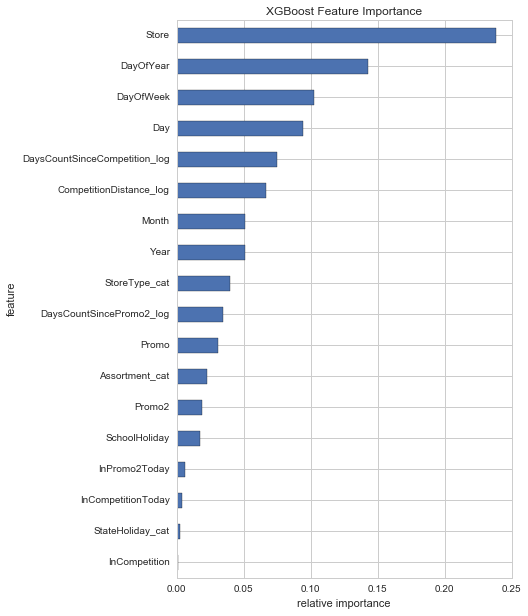

In [241]:
# XGB feature importances
# Based on https://www.kaggle.com/mmueller/liberty-mutual-group-property-inspection-prediction/xgb-feature-importance-python/code
features=feature_x_list
def create_feature_map(features):
    outfile=open('xgb.fmap','w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i,feat))
    outfile.close()
create_feature_map(features)
importance=gbm_15.get_fscore(fmap='xgb.fmap')
importance=sorted(importance.items(),key=operator.itemgetter(1))

df=pd.DataFrame(importance,columns=['feature','fscore'])
df['fscore']=df['fscore']/df['fscore'].sum()

featp=df.plot(kind='barh',x='feature',y='fscore',legend=False,figsize=(6,10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
# fig_featp=featp.get_figure()
# fig_featp.savefig('Kaggle_Kernel_3_XGBoost_Feature_Importance/feature_importance_xgb.png',bbox_inches='tight',pad_inches=1)


#### 5.2 最终模型的预测值与实际值差值绝对值

mean=654.5
median=469.2
max=32403.2
min=0.0
sum=30009543.0


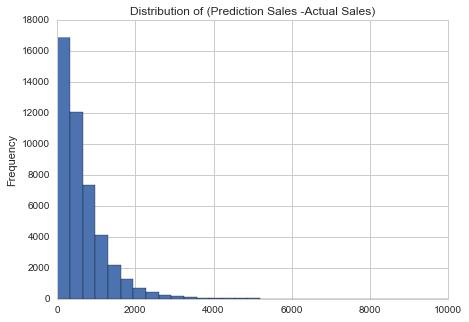

In [209]:
y_diff=np.abs(np.exp(y_valid)-np.exp(yhat_15))
print 'mean={:.1f}'.format(y_diff.mean())
print 'median={:.1f}'.format(y_diff.median())
print 'max={:.1f}'.format(y_diff.max())
print 'min={:.1f}'.format(y_diff.min())
print 'sum={:.1f}'.format(y_diff.sum())
fig,(axis1)=plt.subplots(1,1,figsize=(7,5))
#Sales
_ =y_diff.plot(kind='hist',bins=100,xlim=(0,10000),ax=axis1,title='Distribution of (Prediction Sales -Actual Sales)')

#### 5.3 基准模型的预测值与实际值差值绝对值

mean=756.3
median=534.0
max=32626.0
min=0.0
sum=34669773.0


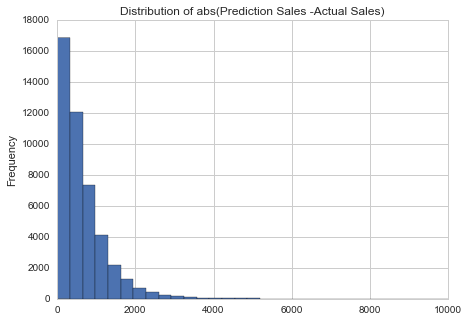

In [217]:
mask=valid_df['Open']==1
y_diff_=np.abs((valid_df['Sales']-valid_df['Sales_Predicted'])[mask])
print 'mean={:.1f}'.format(y_diff_.mean())
print 'median={:.1f}'.format(y_diff_.median())
print 'max={:.1f}'.format(y_diff_.max())
print 'min={:.1f}'.format(y_diff_.min())
print 'sum={:.1f}'.format(y_diff_.sum())
fig,(axis1)=plt.subplots(1,1,figsize=(7,5))
#Sales
_ =y_diff.plot(kind='hist',bins=100,xlim=(0,10000),ax=axis1,title='Distribution of abs(Prediction Sales -Actual Sales)')

#### 5.4 基准模型vs最终模型的预测值与实际值差值绝对值

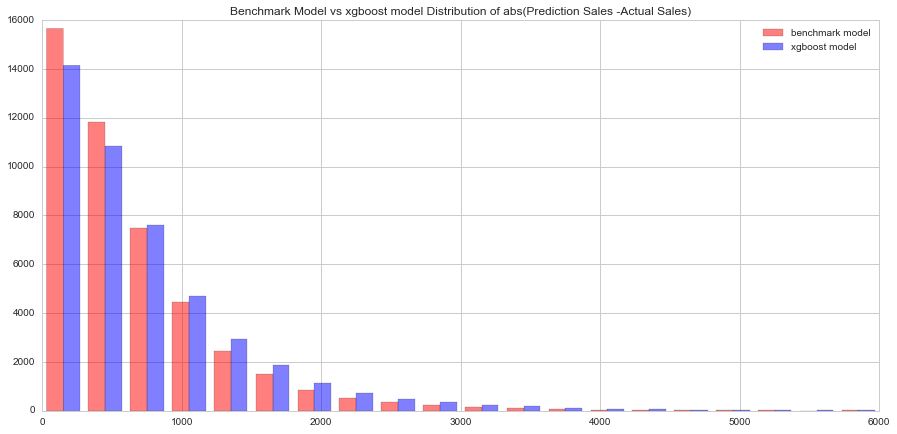

In [239]:
plt.figure(figsize=(15,7))
plt.hist([y_diff,y_diff_],
         color=['r','b'], 
         alpha=0.5,
         range=[0,6000],
         bins=20,
         label=['benchmark model','xgboost model'])
plt.legend(loc='upper right')

plt.title('Benchmark Model vs xgboost model Distribution of abs(Prediction Sales -Actual Sales)')

plt.show()